# Edge Cases: The Making of Network Navigator and Critical Approaches to DH Tools

 ### John R. Ladd [![orcid](https://orcid.org/sites/default/files/images/orcid_16x16.png)](https://orcid.org/0000-0002-5440-062X) 
Washington and Jefferson College

### Zoe LeBlanc [![orcid](https://orcid.org/sites/default/files/images/orcid_16x16.png)](https://orcid.org/0000-0003-2012-8805) 
University of Illinois Urbana-Champaign

[![cc-by-nc-nd](https://licensebuttons.net/l/by-nc-nd/4.0/88x31.png)](https://creativecommons.org/licenses/by-nc-nd/4.0/) 
© John R. Ladd and Zoe LeBlanc. Published by De Gruyter in cooperation with the University of Luxembourg Centre for Contemporary and Digital History. This is an Open Access article distributed under the terms of the [Creative Commons Attribution License CC-BY-NC-ND](https://creativecommons.org/licenses/by-nc-nd/4.0/)


NetworkAnalysis, Networks, Visualization, Tools, DH

This article will explore the role of network analysis research tools as/in scholarly infrastructure, and also detail our attempt to intervene in these practices by building *Network Navigator*, a browser tool for network analysis. In making *Network Navigator*, we intentionally contributed to an existing ecosystem of network analysis tools, namely *Gephi* and *Palladio*, but we were also motivated to combine the principles of minimal computing with new developments in web architecture and DH. We believe our perspective helps complicate our understanding of “tool”-building, making visible the obscured interpretive work of DH infrastructure. Given the centrality of GUI tools in introductory DH pedagogy, we believe that the making and maintaining of DH tools remains one of the profoundly influential, and yet consistently under theorized, areas of DH scholarship and teaching. Even as tools seem to be so foundational to DH, at the same time they remain rarely debated or even defined as a category. Rather than treating ‘tools’ as simply technical objects, we want to critically examine how their design and materiality directly shapes this conceptual amorphousness, but also more profoundly how this definitional problem makes it difficult to discern the ways DH tools are determining larger DH systems and infrastructure.

## Nodes: Introducing the Network Navigator Tool and Intervening in Network Analysis Practices in DH

Since ‘Digital Humanities’ was first coined, debating the question of “what is Digital Humanities (DH)” has become so established that even asking it functions as a meta-discourse. And yet, even though the answers vary widely, many of them often include some reference to “DH tools.” 

To start to explore how tools have become so central in DH, this article utilizes a number of datasets, the first of which is Jason Heppler's dataset from `whatisdigitalhumanities.com`, accessed via https://github.com/hepplerj/whatisdigitalhumanities. This dataset contains quotations from the Day of DH between 2009-2014. As of January 2015, the database contains 817 rows. We used this dataset to explore how frequently the term tool is used in these definitions of DH.

To analyze this data, we first import the relevant libraries and check if we need to download additional packages for text analysis, as well as setting the path to our data directory.

In [1]:
import pandas as pd
import os
import json
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

import altair as alt
alt.data_transformers.disable_max_rows()
# Check if running in Visual Studio Code
if 'VSCODE_CWD' in os.environ:
    alt.renderers.enable('mimetype')

article_data_directory_path = "./script/data" # Where all the article data is stored
original_data_directory_path = "./explorations/datasets/" # Where the original data is stored

Then we read in the dataset and count the frequency of the word `tool` in the definitions. As Ted Underwood has argued, word counts, though seemingly very straightforward and even basic, can be a powerful tool for exploring change in language and deciding how to count requires many interpretative choices that can shape our results.<cite data-cite="14009734/PNJPRYAP"></cite> For a more detailed explanation of the methods we used, see our `CountingTools.ipynb` notebook, but primarily we are using a combination of *lowercasing* the textual data for consistency and then *tokenizing* this data, and finally searching for matches in tokens rather than strings. This choice is intentional since we are primarily interested in the frequency of tool names or terms, like network analysis, and so we want to gather as many instances of this as possible without being so permissive that we capture words that contain these terms.

Our choice to utilize word counting and not more complex methods is also intentional, since we are primarily interested in how popular tools and networks have become in DH, and less so exploring how the language around these terms have changed (something we hope to explore in future work). 

In [2]:
# Define the path to the output CSV file
output_csv_path = f"{article_data_directory_path}/csvs/whatisdh_df.csv"

# Check if the output CSV file exists
if os.path.exists(output_csv_path):
    # If it exists, load the data from the output CSV file
    whatisdh_quotes_df = pd.read_csv(output_csv_path)
else:
    # If it doesn't exist, load the data from the original CSV file
    whatisdh_quotes_df = pd.read_csv(f"{original_data_directory_path}dayofquotes_full.csv")

    # Add a 'quote_id' column based on the DataFrame index
    whatisdh_quotes_df['quote_id'] = whatisdh_quotes_df.index

    # Add a 'lower_quote' column with the lowercase version of the 'quote' column
    whatisdh_quotes_df['lower_quote'] = whatisdh_quotes_df['quote'].str.lower()

    # Add a 'lower_tokenized_quote' column with the tokenized version of the 'lower_quote' column
    whatisdh_quotes_df['lower_tokenized_quote'] = whatisdh_quotes_df['lower_quote'].apply(word_tokenize)

    # Convert the 'date' column to datetime format
    whatisdh_quotes_df['date'] = pd.to_datetime(whatisdh_quotes_df['date'])

    # Add a 'year' column based on the 'date' column
    whatisdh_quotes_df['year'] = whatisdh_quotes_df['date'].dt.year

    # Add a 'quote_length' column with the length of each tokenized quote
    whatisdh_quotes_df['quote_length'] = whatisdh_quotes_df['lower_tokenized_quote'].apply(len)

    # Add a 'tool_frequency' column with the count of 'tool' in each tokenized quote
    whatisdh_quotes_df['tool_frequency'] = whatisdh_quotes_df['lower_tokenized_quote'].apply(lambda x: sum([1 for token in x if 'tool' in token]))

    # Add a 'scaled_tool_frequency' column with the 'tool_frequency' scaled by the 'quote_length'
    whatisdh_quotes_df['scaled_tool_frequency'] = whatisdh_quotes_df['tool_frequency'] / whatisdh_quotes_df['quote_length']

    # Group the DataFrame by 'year' and calculate the sum of 'quote_length', 'tool_frequency', and 'scaled_tool_frequency' for each year
    yearly_tool_counts_df = whatisdh_quotes_df.groupby(['year']).agg({'quote_length': 'sum', 'tool_frequency': 'sum', 'scaled_tool_frequency': 'sum'}).reset_index()

    # Group the DataFrame by 'year' and calculate the total count for each year
    yearly_counts_df = whatisdh_quotes_df.groupby('year').size().reset_index(name='total_counts')

    # Group the DataFrame by 'year' and calculate the count of quotes with 'tool' for each year
    yearly_tool_whatisdh_quotes_df = whatisdh_quotes_df[whatisdh_quotes_df.tool_frequency > 0].groupby(['year']).size().reset_index(name='tool_counts')

    # Merge the total counts and tool counts DataFrames on the 'year' column
    merged_counts_df = pd.merge(yearly_counts_df, yearly_tool_whatisdh_quotes_df, on='year', how='outer')

    # Merge the merged counts DataFrame and the tool counts DataFrame on the 'year' column
    final_counts_whatisdh_df = pd.merge(merged_counts_df, yearly_tool_counts_df, on='year', how='outer')

    # Add a 'ratio' column with the ratio of 'tool_counts' to 'total_counts'
    final_counts_whatisdh_df['ratio'] = final_counts_whatisdh_df['tool_counts'] / final_counts_whatisdh_df['total_counts']

    # Reshape the DataFrame from wide format to long format, with 'year' and 'ratio' as the identifier variables, and 'total_counts' and 'tool_counts' as the variable names
    reshaped_whatisdh_df = pd.melt(final_counts_whatisdh_df, id_vars=['year', 'ratio'], value_vars=['total_counts', 'tool_counts'])

    # Replace 'total_counts' with 'Total Number of Quotes By Year' in the 'variable' column
    reshaped_whatisdh_df.loc[reshaped_whatisdh_df['variable'] == 'total_counts', 'variable'] = 'Total Number of Quotes By Year'

    # Replace 'tool_counts' with 'Total Number of Quotes Containing "Tool" By Year' in the 'variable' column
    reshaped_whatisdh_df.loc[reshaped_whatisdh_df['variable'] == 'tool_counts', 'variable'] = 'Total Number of Quotes Containing "Tool" By Year'

    # Write the DataFrame to the output CSV file
    whatisdh_quotes_df.to_csv(output_csv_path, index=False)

Finally, we visualize the results both over time and by correlation to the total number of words in each definition.

In [3]:
whatisdh_chart_output_path = f"{article_data_directory_path}/charts/whatisdh_chart.json"

# Check if the chart file exists
if os.path.exists(whatisdh_chart_output_path):
    # Load the chart from the JSON file
    with open(whatisdh_chart_output_path) as json_file:
        whatisdh_chart_dict = json.load(json_file)
    whatisdh_chart = alt.Chart.from_dict(whatisdh_chart_dict)
else:
    # Create a bar chart
    time_chart = alt.Chart(reshaped_whatisdh_df).mark_bar().encode(
        x=alt.X('year:O', title='Year', axis=alt.Axis(labelAngle=0)),
        y=alt.Y('value:Q', title='Total number of quotes defining DH'),
        color=alt.Color('variable:N', legend=alt.Legend(title='', orient='bottom', symbolLimit=0, labelLimit=400)),
        tooltip=[
            alt.Tooltip('year', title='Year'),
            alt.Tooltip('value', title='Total Number of Quotes'),
            alt.Tooltip('variable', title='Quote Category'),
            alt.Tooltip('ratio', title='Ratio of Quotes', format='.2f')
        ]
    ).properties(
        title={'text': 'Change in Number of Quotes Containing "Tool" Over Time', 'fontSize': 12},
        width=400,
        height=300
    )

    # Define the dependent and independent variables
    X = final_counts_whatisdh_df['tool_frequency']
    y = final_counts_whatisdh_df['quote_length']

    # Add a constant to the independent variable
    X = sm.add_constant(X)

    # Perform the OLS regression
    model = sm.OLS(y, X)
    results = model.fit()

    # Get the R-squared value
    r_squared = results.rsquared

    # Create the chart
    chart = alt.Chart(final_counts_whatisdh_df).mark_circle().encode(
        x=alt.X('tool_frequency', axis=alt.Axis(title='Frequency of "tool" in any quote defining DH')),
        y=alt.Y('quote_length', axis=alt.Axis(title='Length of any quote defining DH')),
        color=alt.Color('year:N', legend=alt.Legend(title='Year of Quote'), scale=alt.Scale(scheme='plasma')),
        size='ratio',
        tooltip=[
            alt.Tooltip('year', title='Year'),
            alt.Tooltip('tool_frequency', title='Frequency of Tool in Quote'),
            alt.Tooltip('quote_length', title='Quote Length'),
            alt.Tooltip('scaled_tool_frequency', title='Scaled Frequency of Tool in Quote', format='.2f'),
        ]
    ).properties(
        title={'text': 'Correlation Between Frequency of "Tool" in Quotes', 'fontSize': 12},
        width=300,
    )

    # Add the regression line
    combined_chart = chart + chart.transform_regression('tool_frequency', 'quote_length', method="linear").mark_line(color='red').encode(color=alt.Color(legend=None))

    # Add the R-squared value as a text mark
    text = alt.Chart({'values':[{'x': 0, 'y': 0}]}).mark_text(
        text=f'R-squared: {r_squared:.2f}',
        align='left',
        baseline='top',
        color='black',
        dx=5  # Nudges text to right so it doesn't appear on top of the bar
    ).encode(
        x=alt.value(0),  # pixels from left
        y=alt.value(0),  # pixels from top
    )

    # Combine the charts
    final_chart = combined_chart + text

    whatisdh_chart = (alt.hconcat(time_chart, final_chart).resolve_scale(color='independent', y="independent").properties(title="Frequency of 'Tool' in Quotes From whatisdigitalhumanities.com and Day of DH").configure(
            title=alt.TitleConfig(fontSize=20, font='Garamond', anchor='middle'),
            axis=alt.AxisConfig(labelFont='Garamond', titleFont='Garamond'),
            legend=alt.LegendConfig(labelFont='Garamond', titleFont='Garamond')
        ))
    whatisdh_chart.save(whatisdh_chart_output_path)
whatisdh_chart

alt.HConcatChart(...)

The first graph shows that the term tool is used more frequently in the definitions of DH over time, and the second graph shows that this frequency has a positive correlation as quotes get longer over time. This suggests that the term tool is becoming more central to the definition of DH, even as definitions of DH become more verbose.

In addition to frequency, we can also look at the words themselves though generating a word cloud. We can see that the word "tool" is one of the most common words in the definitions of DH.

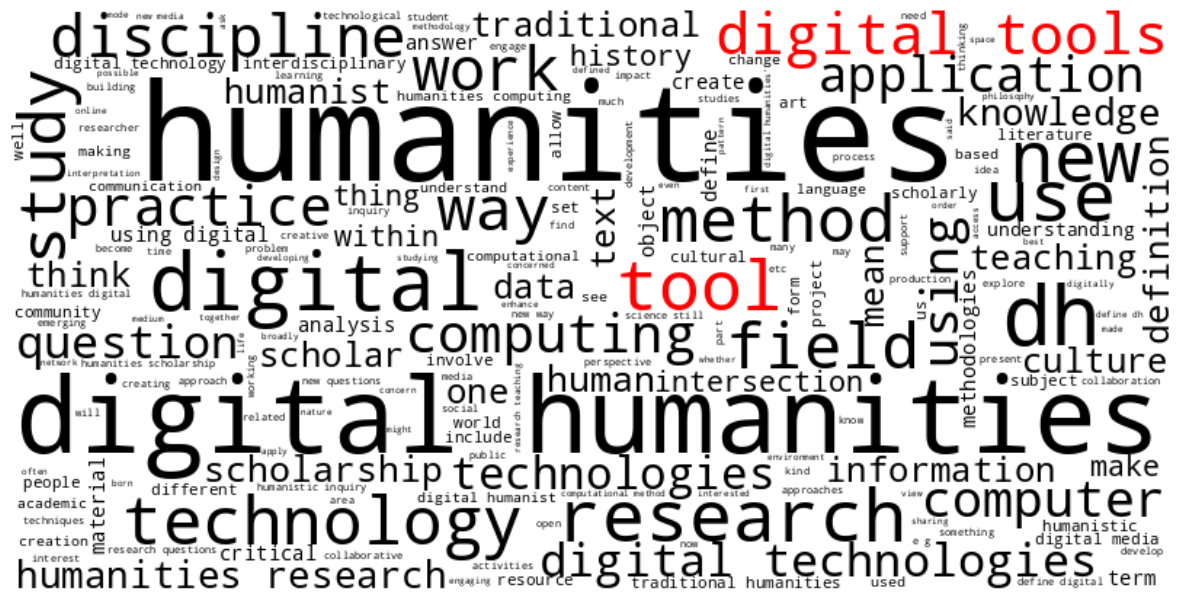

In [4]:
# Import the wordcloud library and matplotlib
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

# Define a function to color the word cloud
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    if 'tool' in word:
        return 'red'
    else:
        return 'black'

# Join the 'lower_quote' column into a single string
text = ' '.join(whatisdh_quotes_df.lower_quote.astype(str))
# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white', color_func=color_func).generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.show()

In this graph, we can see that `tool` and `digital tools` are both prominently sized in the word cloud, suggesting that the term tool is used relatively frequently in the definitions of DH. While such word counts and word clouds are not definitive, these methods help suggest that this trend exists and is worth further investigation. 

While the tools referenced have changed over time, increasingly many of those most consistently used and cited have been tools intended for network analysis.  

In addition to looking at the popularity of `tool`, we can also explore the popularity of tools specifically for network analysis in DH. To do this, we identified a list of tools for network analysis in DH, based partially on our own experiences and through the list available on the Text Analysis Portal for Research (TAPoR) at http://tapor.ca/tools/category/Network%20Analysis. We did not include tools that are primarily for data visualization and might have the ability to visualize networks, but are not specifically for network analysis (such as Tableau, RAWGraphs, Voyant Tools, D3.js, etc.) in our list of network analysis-specific tools.

In [5]:
# Create a list of all primariy network analysis tools
network_tools = ['Gephi', 'Palladio', 'nodegoat', 'igraph', 'Textexture', 'Netlytic', 'sigma.js', 'Neo4j', 'NetworkX', 'NodeXL', 'Graphviz', 'Cytoscape']

Then we imported any additional required libraries and created a set of shared functions to identify these terms across our datasets.

In [6]:
import numpy as np
from typing import List, Optional, Tuple
from sklearn.feature_extraction.text import CountVectorizer

def count_term_frequencies(df: pd.DataFrame, text_column: str, term_list: List[str]) -> pd.DataFrame:
    """
    Vectorize the text and count the frequencies of specific terms.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    text_column (str): The name of the column in df that contains the text to process.
    term_list (List[str]): A list of terms for which to calculate frequencies.

    Returns:
    term_freq_df (pd.DataFrame): A DataFrame where each column corresponds to a term in term_list and the values are the frequencies of the term in each document.
    """
    # Initialize CountVectorizer with the provided terms as the vocabulary
    count_vec = CountVectorizer(ngram_range=(1,2), vocabulary=term_list)

    # Fit and transform the text data
    X = count_vec.fit_transform(df[text_column]).toarray()

    # Create a DataFrame with the term frequencies
    term_freq_df = pd.DataFrame(X, columns=count_vec.get_feature_names_out())

    # For terms that contain a period, use straight string matching
    for term in term_list:
        if '.' in term:
            term_freq_df[term] = df[text_column].str.count(term)

    return term_freq_df


def generate_word_counts(subset_df: pd.DataFrame, text_column: str, terms_list: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Process a DataFrame to calculate term frequencies and tokenize text.

    Parameters:
    subset_df (pd.DataFrame): The input DataFrame.
    text_column (str): The name of the column in subset_df that contains the text to process.
    terms_list (List[str]): A list of terms for which to calculate frequencies.

    Returns:
    combined_df (pd.DataFrame): The original DataFrame, with additional columns for the lowercased text, tokenized text, token frequencies, and total tokens.
    """
    if 'lower_text' not in subset_df.columns:
        subset_df['lower_text'] = subset_df[text_column].str.lower()

    if 'total_tokens' not in subset_df.columns:
        subset_df['total_tokens'] = subset_df['lower_text'].str.split(' ').str.len()
    
    count_df = count_term_frequencies(subset_df, 'lower_text', terms_list)
    combined_df = pd.concat([subset_df, count_df], axis=1)
    
    return combined_df

def process_data(file_path: str, text_column: str, date_column: str, terms_list: List, data_origin: str, title: str, term_type: str, term_mapping: bool, joined_term: Optional[str] = None):
    """
    Process the data and calculate term frequencies.

    Args:
        file_path (str): The path to the CSV file.
        text_column (str): The name of the column containing the text data.
        date_column (str): The name of the column containing the date data.
        terms_list (List): A list of terms to calculate frequencies for.
        data_origin (str): The origin of the data.
        title (str): The title of the data.
        term_type (str): The type of term data.
        term_mapping (bool): Whether to map term names for formatting variables.
        joined_term (str, optional): A term that we've searched for in multiple formats that we want to normalize into one term. Defaults to None.

    Returns:
        pd.DataFrame: The processed and calculated DataFrame.
    """
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Create a subset of the DataFrame that only includes rows where 'full_text' is not null
    subset_df = df[df[text_column].notna()]
    subset_df = subset_df.reset_index(drop=True)
    # Create a 'cleaned_conference_year' column by converting the 'conference_year' column to string and appending "-01-01"
    subset_df[f"cleaned_{date_column}"] = subset_df[date_column].astype(str) + "-01-01"

    # Convert the 'cleaned_conference_year' column to datetime format
    subset_df[f"cleaned_{date_column}"] = pd.to_datetime(subset_df[f"cleaned_{date_column}"])

    original_terms_list = terms_list.copy()
    lower_terms_list = [term.lower() for term in terms_list]

    # Process the DataFrame to calculate term frequencies and tokenize text
    combined_df = generate_word_counts(subset_df, text_column, lower_terms_list)
    # If a tool column is provided, create the 'finalized_tool' column
    if joined_term:
        plural_joined_term = joined_term + "s"
        combined_df[f'finalized_{joined_term}'] = np.where(combined_df[joined_term].notnull(), combined_df[joined_term], combined_df[plural_joined_term])
        combined_df = combined_df.drop(columns=[joined_term, plural_joined_term])
        combined_df = combined_df.rename(columns={f"finalized_{joined_term}": joined_term})

    id_vars_columns = subset_df.columns.tolist()
    melted_combined_df = pd.melt(combined_df, id_vars=id_vars_columns, var_name=term_type, value_name='counts')
    melted_combined_df['scaled_counts'] = melted_combined_df['counts'] / melted_combined_df['total_tokens']
    
    # If term mapping is enabled, map the terms
    if term_mapping:
        # Create a mapping from lowercase tool name to the correct name
        term_mapping = {term.lower(): term for term in original_terms_list}
        melted_combined_df[term_type] = melted_combined_df[term_type].replace(term_mapping)

    # Group the DataFrame by 'cleaned_conference_year' and 'tool' and calculate the sum of 'counts' for each group, then reset the index
    summed_df = melted_combined_df.groupby([f"cleaned_{date_column}", term_type]).counts.sum().reset_index()

    # Group the DataFrame by 'cleaned_conference_year' and 'tool' and calculate the sum of 'scaled_counts' for each group, then reset the index
    scaled_df = melted_combined_df.groupby([f"cleaned_{date_column}", term_type]).scaled_counts.sum().reset_index()

    # Group the DataFrame by 'cleaned_conference_year' and calculate the sum of 'total_tokens' for each group, then reset the index
    total_tokens_df = melted_combined_df.groupby([f"cleaned_{date_column}", term_type]).total_tokens.sum().reset_index()

    # Merge the grouped DataFrames
    grouped_df = pd.merge(summed_df, scaled_df, on=[f"cleaned_{date_column}", term_type])

    # Merge the grouped DataFrame with the total tokens DataFrame
    grouped_df = pd.merge(grouped_df, total_tokens_df, on=[f"cleaned_{date_column}", term_type])

    # Multiply the 'scaled_counts' column by 100
    grouped_df.scaled_counts = grouped_df.scaled_counts * 100

    # Rename the 'cleaned_conference_year' column to 'date'
    grouped_df = grouped_df.rename(columns={f"cleaned_{date_column}": "date"})

    # Add a 'data_origin' column 
    grouped_df["data_origin"] = data_origin

    # Add a 'title' column
    grouped_df["title"] = title

    return grouped_df

Now we can start loading in our datasets and processing them with these functions. For the sake of speed, we have presaved the output of our analysis to be loaded in the charts as json files. However, you can rerun this analysis by setting the rerun variable to True.

In [7]:
# Define paths to charts json
network_tools_over_time_chart_output_path = f"{article_data_directory_path}/charts/network_tools_over_time_chart.json"
relative_popularity_chart_output_path = f"{article_data_directory_path}/charts/relative_popularity_chart.json"
rerun_chart_code = True # Set to True to rerun the code to generate the charts

Our first dataset was downloaded from Barbot, Laure, Frank Fischer, Yoann Moranville, and Ivan Pozdniakov. “Which DH Tools Are Actually Used in Research?,” December 6, 2019. https://weltliteratur.net/dh-tools-used-in-research/, which scraped a list of tools from TaPoR and compared them to the proceedings of DH2015 to DH2019.

In [8]:
# Check if the files exist and if the code should be rerun
if (os.path.exists(network_tools_over_time_chart_output_path) == False) or (os.path.exists(relative_popularity_chart_output_path) == False) or rerun_chart_code:
    # Load the CSV file into a DataFrame
    tapor_adho_df = pd.read_csv(f"{original_data_directory_path}tools-dh-proceedings.csv")

    # Reshape the DataFrame from wide format to long format, with 'Tool' as the identifier variable, 'year' as the variable name, and 'counts' as the value name
    melted_tapor_adho_df = tapor_adho_df.melt(id_vars=['Tool'], var_name='year', value_name='counts')

    # Create a 'date' column by concatenating the 'year' column with '-01-01' to represent the first day of the year
    melted_tapor_adho_df['date'] = melted_tapor_adho_df['year'].astype(str) + '-01-01'

    # Convert the 'date' column to datetime format
    melted_tapor_adho_df['date'] = pd.to_datetime(melted_tapor_adho_df['date'])

    # Group the DataFrame by 'Tool' and calculate the sum of 'counts' for each tool, then reset the index
    grouped_dh_tools = melted_tapor_adho_df.groupby(['year'])['counts'].sum().reset_index().rename(columns={"counts": "total_tokens"})

    # Merge the melted DataFrame with the grouped DataFrame on the 'year' column
    merged_tapor_adho_df = pd.merge(melted_tapor_adho_df, grouped_dh_tools, on='year', how='outer')

    # Create a subset of the DataFrame that only includes rows where 'Tool' is in 'network_tools'
    subset_tapor_adho_df = merged_tapor_adho_df[merged_tapor_adho_df.Tool.isin(network_tools)]

    # Drop the 'year' column from the subset DataFrame
    subset_tapor_adho_df = subset_tapor_adho_df.drop(columns=["year"])

    # Rename the 'Tool' column to 'tool'
    subset_tapor_adho_df = subset_tapor_adho_df.rename(columns={"Tool": "tools"})

    # Add a 'data_origin' column with the value 'TaPoR'
    subset_tapor_adho_df["data_origin"] = "TaPoR"

    # Add a 'title' column with the value 'TaPoR and DH Conferences Data by Barbot et al. (2019)'
    subset_tapor_adho_df["title"] = "TaPoR and DH Conferences Data by Barbot et al. (2019)"

    # Set scaled counts to None
    subset_tapor_adho_df['scaled_counts'] = subset_tapor_adho_df['counts'] / subset_tapor_adho_df['total_tokens'] * 100

Next we have Weingart, S.B., Eichmann-Kalwara, N., Lincoln, M., et al. 'DH Conferences Data Extract' in *The Index of Digital Humanities Conferences*. Carnegie Mellon University, 2020. Data last updated 2023-09-20. https://dh-abstracts.library.cmu.edu. https://doi.org/10.34666/k1de-j489, which we downloaded from https://dh-abstracts.library.virginia.edu/downloads. Technically this data somewhat overlaps with the previous dataset, but this one covers a larger time period and includes more conferences, so we have included both to enable the most comprehensive analysis and to allow comparison between the two since they were compiled using differing mechanisms.

In [9]:
# Check if the files exist and if the code should be rerun
if (os.path.exists(network_tools_over_time_chart_output_path) == False) or (os.path.exists(relative_popularity_chart_output_path) == False) or rerun_chart_code:
    grouped_index_conferences_df = process_data(
        file_path=f"{original_data_directory_path}/dh_conferences_works.csv",
        text_column="full_text",
        date_column="conference_year",
        terms_list=network_tools,
        data_origin="Index of DH Conferences",
        title="Index of DH Conferences by Weingart et al (2023)",
        term_type="tools",
        term_mapping=True,
        joined_term=None
    )

The final dataset is the entire run of *Digital Humanities Quarterly* (DHQ). This dataset comes from the DHQ website (https://digitalhumanities.org/dhq/), and the data was scraped and compiled from XML files available here https://github.com/Digital-Humanities-Quarterly/dhq-journal/tree/main/data/dhq-xml. All the code and data is available in this GitHub repository https://github.com/ZoeLeBlanc/dhq_scraper.

In [10]:
# Check if the files exist and if the code should be rerun
if (os.path.exists(network_tools_over_time_chart_output_path) == False) or (os.path.exists(relative_popularity_chart_output_path) == False) or rerun_chart_code:
    grouped_dhq_df = process_data(
        file_path=f"{original_data_directory_path}/private_data/dhq_data.csv",
        text_column="body_text",
        date_column="date_published",
        terms_list=network_tools,
        data_origin="DHQ",
        title="DHQ Articles (2023)",
        term_type="tools",
        term_mapping=True,
        joined_term=None
    )
   

Now that we have the datasets processed, we can start looking at trends in network analysis tools over time. 

In [11]:
# Define colors for each tool to use the same colors across charts
color_network_map = {
    'Gephi': '#4c78a8', 
    'Palladio': '#aec7e8', 
    'nodegoat': '#ff7f0e', 
    'igraph': '#ffbb78', 
    'Textexture': '#2ca02c', 
    'Netlytic': '#98df8a', 
    'sigma.js': '#d62728', 
    'Neo4j': '#ff9896', 
    'NetworkX': '#9467bd', 
    'NodeXL': '#c5b0d5', 
    'Graphviz': '#8c564b', 
    'Cytoscape': '#c49c94'
    }

In [12]:
# Check if the chart file exists
if os.path.exists(network_tools_over_time_chart_output_path):
    # Load the chart from the JSON file
    with open(network_tools_over_time_chart_output_path) as json_file:
        network_tools_over_time_chart_dict = json.load(json_file)
    network_tools_over_time_chart = alt.Chart.from_dict(network_tools_over_time_chart_dict)
else:
    # Concatenate the three DataFrames into one
    combined_df = pd.concat([subset_tapor_adho_df, grouped_index_conferences_df, grouped_dhq_df])
    combined_df = combined_df.reset_index(drop=True)

    combined_df.date = combined_df.date.astype(str)
    combined_df.date = combined_df.date.str.split(" ").str[0]
    combined_df['date'] = pd.to_datetime(combined_df.date, format='%Y-%m-%d')
    combined_df = combined_df.rename(columns={"counts": "Raw Frequency of Mentions", "scaled_counts": "Frequency of Mentions Scaled by Total Tokens"})
    # Get a list of unique data origins
    data_origins = combined_df.data_origin.unique().tolist()

    # Initialize an empty list to store the charts
    charts = []

    # Get a list of unique tools
    list_tools = combined_df.tools.unique().tolist()

    # Create a list of colors for each tool
    color_list = [color_network_map[tool] for tool in list_tools]

    # Create a dropdown selection
    dropdown = alt.binding_select(
        options=['Raw Frequency of Mentions', 'Frequency of Mentions Scaled by Total Tokens'], 
        name='Select Counting Method on Y Axis'
    )
    ycol_param = alt.param(
        value="Raw Frequency of Mentions", 
        bind=dropdown
    )
    # Create a selection that allows the user to select points in the legend
    selection = alt.selection_multi(fields=['tools'], bind='legend')
    # Loop over each data origin
    # Create a color scale for the chart
    color_scale = alt.Scale(
            domain=list_tools,
            range=color_list
        )
    for data_origin in data_origins:
        # Create a subset of the DataFrame that only includes rows where 'data_origin' is the current data origin
        subset_df = combined_df[combined_df.data_origin == data_origin]
        # Set the width of the chart depending on the data origin
        width = 500 if data_origin != "TaPoR" else 300

        # Get the title of the chart from the 'title' column of the subset DataFrame
        title = subset_df.title.unique()[0]

        new_chart = alt.Chart(subset_df).mark_bar().encode(
            # Encode the 'year' column as the x-axis
            x=alt.X('year(date):T',  axis=alt.Axis(title="Year")),
            # Encode the 'counts' column as the y-axis
            y=alt.Y('y:Q', axis=alt.Axis(title="Frequency of Mentions")),
            # Encode the 'tool' column as the color
            color=alt.Color('tools:N', legend=alt.Legend(title="Tool"), scale=color_scale),
            # Set the opacity of the bars depending on the selection
            opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
            # Set the tooltip to show the 'tool', 'counts', 'date', and 'Frequency of Mentions Scaled by Total Tokens' columns
            tooltip=[
                alt.Tooltip('tools', title='Tool'),
                alt.Tooltip('Raw Frequency of Mentions'),
                alt.Tooltip('date:T', title='Date', format='%Y'),
                alt.Tooltip('Frequency of Mentions Scaled by Total Tokens'),
                alt.Tooltip('total_tokens', title='Total Tokens'),
            ]
        ).transform_calculate(
                y=f'datum[{ycol_param.name}]'
            ).add_params(
                ycol_param, selection
            ).properties(
            # Set the title and width of the chart
            title=f"{title}",
            width=width
        )
        

        # Add the chart to the list of charts
        charts.append(new_chart)

    # Concatenate the charts horizontally
    network_tools_over_time_chart = alt.hconcat(*charts).properties(
        # Set the title of the concatenated chart
        title={
            "text": "Popularity of Network Analysis Tools Over Time and Across Multiple Datasets",
            "subtitle": ["The Y-Axis can be changed to show either the raw frequency of a tool name in each respective dataset", "or the frequency of mentions scaled by all tokens for that year."]
        }
    ).configure(
        # Configure the title, axis, and legend of the chart
        title=alt.TitleConfig(fontSize=20, font='Garamond', anchor='middle'),
        axis=alt.AxisConfig(labelFont='Garamond', titleFont='Garamond'),
        legend=alt.LegendConfig(labelFont='Garamond', titleFont='Garamond')
    )
    network_tools_over_time_chart.save(network_tools_over_time_chart_output_path)

# Display the concatenated chart
network_tools_over_time_chart

alt.HConcatChart(...)

We can also consider the relative popularity of network analysis tools compared to other most popular tools in DH, using the list from TAPoR.

In [13]:
# Check if the chart file exists
if os.path.exists(relative_popularity_chart_output_path):
    # Load the chart from the JSON file
    with open(relative_popularity_chart_output_path) as json_file:
        relative_popularity_chart_dict = json.load(json_file)
    relative_popularity_chart = alt.Chart.from_dict(relative_popularity_chart_dict)
else:
    # Get a list of unique tools
    grouped_merged_dh_tools = merged_tapor_adho_df.groupby(['Tool'])['counts'].sum().reset_index()

    total_tokens = grouped_merged_dh_tools['counts'].sum()
    grouped_merged_dh_tools['scaled_counts'] = grouped_merged_dh_tools['counts'] / total_tokens * 100
    all_dh_tools = grouped_merged_dh_tools.Tool.unique().tolist()

    # Get the count of the second most frequent network tool
    second_frequent_network_tool = grouped_merged_dh_tools[grouped_merged_dh_tools.Tool.isin(network_tools)].sort_values(by='counts', ascending=False).head(2)[1:2].counts.values[0]

    # Get a list of tools that have a count greater than or equal to the count of the second most frequent network tool
    updated_network_tools = grouped_merged_dh_tools[grouped_merged_dh_tools.counts >= second_frequent_network_tool].sort_values(by='counts', ascending=False).Tool.unique().tolist()

    # Create a list of colors for each tool
    updated_network_colors = [color_network_map[tool] if tool in color_network_map else '#bab0ac' for tool in updated_network_tools]
    grouped_merged_dh_tools = grouped_merged_dh_tools.rename(columns={"counts": "Raw Frequency of Mentions", "scaled_counts": "Frequency of Mentions Scaled by All Tool Mentions"})
    # Create a dropdown selection
    dropdown = alt.binding_select(
        options=["Raw Frequency of Mentions",  "Frequency of Mentions Scaled by All Tool Mentions"], 
        name='Select Counting Method on Y Axis'
    )
    xcol_param = alt.param(
        value="Raw Frequency of Mentions",
        bind=dropdown
    )

    # Create a bar chart of the total tools
    total_tools = alt.Chart(grouped_merged_dh_tools[grouped_merged_dh_tools["Raw Frequency of Mentions"] >= second_frequent_network_tool]).mark_bar().encode(
        x=alt.X('x:Q', title='Number of mentions'),
        y=alt.Y('Tool:N', title='Tool', sort='-x'),
        color=alt.Color('Tool:N', legend=None, scale=alt.Scale(domain=updated_network_tools, range=updated_network_colors)),
    ).transform_calculate(
        x=f'datum[{xcol_param.name}]'
    ).add_params(xcol_param).properties(
        title="TaPoR and DH Conferences Data by Barbot et al. (2019)",
    )

    # Process the DataFrame to calculate term frequencies and tokenize text
    grouped_index_conferences_df = process_data(
        file_path=f"{original_data_directory_path}/dh_conferences_works.csv",
        text_column="full_text",
        date_column="conference_year",
        terms_list=all_dh_tools,
        data_origin="Index of DH Conferences",
        title="Index of DH Conferences by Weingart et al (2023)",
        term_type="all_tools",
        term_mapping=True,
        joined_term=None
    )
    all_tools_index_conferences_df = grouped_index_conferences_df.groupby('all_tools').agg({'counts': 'sum'}).reset_index()

    total_tools = all_tools_index_conferences_df['counts'].sum()
    all_tools_index_conferences_df['scaled_counts'] = all_tools_index_conferences_df['counts'] / total_tools * 100

    # Get the frequency of the second most frequent network tool
    conference_second_frequent_network_tool = all_tools_index_conferences_df[all_tools_index_conferences_df.all_tools.isin(network_tools)].sort_values(by='counts', ascending=False).head(2)[1:2].counts.values[0]

    # Get a list of tools that have a frequency greater than or equal to the frequency of the second most frequent network tool
    conference_updated_network_tools = all_tools_index_conferences_df[all_tools_index_conferences_df.counts >= conference_second_frequent_network_tool].sort_values(by='counts', ascending=False).all_tools.unique().tolist()

    # Create a list of colors for each tool
    conference_updated_network_colors = [color_network_map[tool] if tool in color_network_map else '#bab0ac' for tool in conference_updated_network_tools]


    all_tools_index_conferences_df = all_tools_index_conferences_df.rename(columns={"all_tools": "Tool", 'counts': 'Raw Frequency of Mentions', 'scaled_counts': 'Frequency of Mentions Scaled by All Tool Mentions'})

    # Create a bar chart of the total tools
    conference_total_tools = alt.Chart(all_tools_index_conferences_df[all_tools_index_conferences_df["Raw Frequency of Mentions"] >= conference_second_frequent_network_tool]).mark_bar().encode(
        x=alt.X('x:Q', title='Number of mentions'),
        y=alt.Y('Tool:N', sort='-x'),
        color=alt.Color('Tool:N', legend=None, scale=alt.Scale(domain=conference_updated_network_tools, range=conference_updated_network_colors)),
    ).transform_calculate(
        x=f'datum[{xcol_param.name}]'
    ).add_params(xcol_param).properties(
        title="Index of DH Conferences by Weingart et al (2023)",
    )

    # Process the DataFrame to calculate term frequencies and tokenize text
    grouped_dhq_df = process_data(
        file_path=f"{original_data_directory_path}/private_data/dhq_data.csv",
        text_column="body_text",
        date_column="date_published",
        terms_list=all_dh_tools,
        data_origin="DHQ",
        title="DHQ Articles (2023)",
        id_column="DHQarticle-id",
        term_type="all_tools",
        term_mapping=True,
        joined_term=None
    )

    all_tools_dhq_df = grouped_dhq_df.groupby('all_tools').agg({'counts': 'sum'}).reset_index()
    total_tools = all_tools_dhq_df['counts'].sum()
    all_tools_dhq_df['scaled_counts'] = all_tools_dhq_df['counts'] / total_tools * 100

    # Get the frequency of the second most frequent network tool
    dhq_second_frequent_network_tool = all_tools_dhq_df[all_tools_dhq_df.Term.isin(network_tools)].sort_values(by='counts', ascending=False).head(2)[1:2].counts.values[0]

    # Get a list of tools that have a frequency greater than or equal to the frequency of the second most frequent network tool
    dhq_updated_network_tools = all_tools_dhq_df[all_tools_dhq_df.counts >= dhq_second_frequent_network_tool].sort_values(by='counts', ascending=False).Term.unique().tolist()

    # Create a list of colors for each tool
    dhq_updated_network_colors = [color_network_map[tool] if tool in color_network_map else '#bab0ac' for tool in dhq_updated_network_tools]

    all_tools_dhq_df = all_tools_dhq_df.rename(columns={"all_tools": "Tool", 'counts': 'Raw Frequency of Mentions', 'scaled_counts': 'Frequency of Mentions Scaled by All Tool Mentions'})
    # Create a bar chart of the total tools
    dhq_total_tools = alt.Chart(all_tools_dhq_df[all_tools_dhq_df["counts"] >= dhq_second_frequent_network_tool]).mark_bar().encode(
        x=alt.X('x:Q', title='Number of mentions'),
        y=alt.Y('Tool:N', sort='-x'),
        color=alt.Color('Tool:N', legend=None, scale=alt.Scale(domain=dhq_updated_network_tools, range=dhq_updated_network_colors)),
    ).transform_calculate(
        x=f'datum[{xcol_param.name}]'
    ).add_params(xcol_param).properties(
        title="DHQ Articles (2023)",
    )

    # Concatenate the charts horizontally
    relative_popularity_chart = alt.hconcat(total_tools, conference_total_tools, dhq_total_tools).configure(
        title=alt.TitleConfig(fontSize=20, font='Garamond', anchor='middle'),
        axis=alt.AxisConfig(labelFont='Garamond', titleFont='Garamond'),
        legend=alt.LegendConfig(labelFont='Garamond', titleFont='Garamond')
    ).resolve_scale(color='independent').properties(
        title={
            "text":"Ranking of Most Popular Network Analysis Tools Relative to Other DH Tools Across Multiple Datasets",
            "subtitle": ["The Y-Axis can be changed to show either the raw frequency of a tool name in each respective dataset", "or the frequency of mentions scaled by total references to any tool for that dataset."],
        }
    )
    relative_popularity_chart.save(relative_popularity_chart_output_path)

# Display the concatenated chart
relative_popularity_chart

alt.HConcatChart(...)

While these figures hint at the surging popularity of these tools (and network analysis more broadly), what is only starting to be studied is how this rise of network analysis in DH has been delimited by what these tools can produce.(<cite data-cite="14009734/EGDP6WTJ"></cite>) Consider, for instance, the prevalence of force layout diagrams in DH, colloquially known as the ‘hairball graph.’ Although these diagrams are often criticized for being difficult to interpret in DH, we believe their widespread use is also indicative of the power these “tools” exert on what scholars think is possible with network analysis. Given this influence, we attempted to intervene in these practices by building *Network Navigator*, a browser-based tool for network analysis in DH. 

To give a sense of the background of *Network Navigator*, we can explore the history of the project via the GitHub repository https://github.com/jrladd/network_navigator.

In [14]:
nn_chart_output_path = f"{article_data_directory_path}/charts/nn_chart.json"

# Check if the CSV files exist
if os.path.exists(nn_chart_output_path) or rerun_chart_code:
    with open(nn_chart_output_path) as json_file:
        nn_chart_dict = json.load(json_file)
    nn_chart = alt.Chart.from_dict(nn_chart_dict)
else:
    # Load the CSV files into DataFrames
    nn_repo_df = pd.read_csv(f"{original_data_directory_path}network_navigator_repo.csv")
    nn_commits_df = pd.read_csv(f"{original_data_directory_path}network_navigator_commits.csv")

    # Convert the 'commit.author.date' column to datetime format
    nn_commits_df['commit.author.date'] = pd.to_datetime(nn_commits_df['commit.author.date'], errors='coerce')

    # Replace 'Zoe LeBlanc' with 'ZoeLeBlanc' in the 'commit.author.name' column
    nn_commits_df.loc[nn_commits_df['commit.author.name'] == 'Zoe LeBlanc', 'commit.author.name'] = 'ZoeLeBlanc'

    # Create a subset of the DataFrame that only includes certain columns
    subset_commits_df = nn_commits_df[['commit.author.name', 'commit.author.date', 'stats.total', 'stats.additions', 'stats.deletions']]

    # Replace '.' with '_' in the column names
    cols = subset_commits_df.columns
    cols = [col.replace('.', '_') for col in cols]
    subset_commits_df.columns = cols

    # Prepare data for symmetric bar chart
    df_additions = subset_commits_df[["commit_author_name", "commit_author_date", "stats_additions"]].copy()
    df_additions["type"] = "additions"
    df_additions.rename(columns={"stats_additions": "value"}, inplace=True)

    df_deletions = subset_commits_df[["commit_author_name", "commit_author_date", "stats_deletions"]].copy()
    df_deletions["type"] = "deletions"
    df_deletions["stats_deletions"] = -df_deletions["stats_deletions"]
    df_deletions.rename(columns={"stats_deletions": "value"}, inplace=True)

    # Concatenate the additions and deletions DataFrames
    df_graph = pd.concat([df_additions, df_deletions])

    # Create the symmetric bar chart
    project_history = alt.Chart(df_graph).mark_bar().encode(
        x=alt.X('commit_author_date:T', title="Date"),
        y=alt.Y('value:Q', title="Additions/Deletions"),
        color=alt.Color('type:N', title="Type of Change"),
        tooltip=['commit_author_name:N', 'commit_author_date:T', 'value:Q', 'type:N'],
    ).properties(
        title="Additions and Deletions to Network Navigator",
    )

    # Create a selection that allows the user to select points in the legend
    selection = alt.selection_point(fields=['commit_author_name'], bind='legend')

    # Create a bar chart of the total contributions by each author
    author_chart = alt.Chart(subset_commits_df).mark_bar(opacity=0.7).encode(
        x=alt.X('commit_author_date:T', title='Date'),
        y=alt.Y('stats_total:Q', title='Total Contributions').stack(None),
        color=alt.Color('commit_author_name:N',
            scale=alt.Scale(scheme='tableau20'), 
            legend=alt.Legend(title="Author"),
            sort=alt.EncodingSortField(
                field="stats_total",  # The field to use for the sort
                op="sum",            # The operation to run on the field prior to sorting
                order="descending"   # The sort order
            )
        ),
        tooltip=['commit_author_name:N', 'commit_author_date:T', 'stats_total:Q'],
        opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
    ).add_params(selection).interactive(bind_y=False).properties(
        title="Contributors to Network Navigator",
    )

    # Concatenate the charts horizontally
    nn_chart = alt.hconcat(project_history, author_chart).resolve_scale(y='independent', color='independent').properties(
        title="History of Network Navigator via GitHub"
    ).configure(
        title=alt.TitleConfig(fontSize=20, font='Garamond', anchor='middle'),
        axis=alt.AxisConfig(labelFont='Garamond', titleFont='Garamond'),
        legend=alt.LegendConfig(labelFont='Garamond', titleFont='Garamond')
    )
    nn_chart.save(nn_chart_output_path)

# Display the concatenated chart

nn_chart

alt.HConcatChart(...)

Built initially from 2017-2018 by Ladd, and then redesigned with LeBlanc from 2020-2022, the original impetus for *Network Navigator* was to provide scholars and students a platform that emphasized a deeper understanding and exploration of networks—particularly in terms of metrics and visualizations. Ladd and LeBlanc had observed that for newcomers to networks in DH, most prioritized learning tools, like Gephi or Palladio, which unintentionally neglected the broader question of how to interpret networks, a phenomenon often referred to as ‘button-ology.’<cite data-cite="14009734/7IRLVQ5S"></cite> While Network Navigator aimed to overcome these challenges, its development was also impacted by the onset of the COVID-19 pandemic. This not only influenced how Ladd and LeBlanc collaborated but also necessitated DH tools that were not only easy to use, but that did not require extensive technical setup or installation since most users would be working remotely.

In making *Network Navigator*, we intentionally contributed to this existing and evolving ecosystem of tools, but we were also motivated to build in ways that intentionally prioritized the constraints of DH. Such an approach runs counter to most software development practices that often privilege maximizing user base and scale, which often requires complex infrastructure and the latest frameworks web development. Instead, we carefully considered not only what we could build, but also what we should exclude from this tool. The result is a tool that is not as full featured as other network analysis tools, but we believe that our choices, while still prioritizing users, challenge the default notion of user-friendliness in DH tools (a goal that is rarely defined or until recently, even studied). Thus, Network Navigator is intended to help researchers to understand networks as both an information design technique and a statistical methodology. But how to balance these goals is far from straightforward. Even more fraught is when these tools function as pedagogical instruments, introducing researchers to a methodology—whether that is network analysis, topic modeling, or even counting words, to name but a few of the most popular, current methods. In this scenario, the tool itself can have enormous influence on how scholars understand these methods, thus shaping not only how we research, but also make knowledge claims.

We are far from the first scholars to raise such questions or concerns regarding DH tools. Nonetheless, we believe sharing our journey with *Network Navigator*—from conception to (re)construction—can contribute to the ongoing critical reassessment of the very category of DH tools and their often difficult to discern role in shaping DH knowledge production. With the rise of subfields like Cultural Analytics and Computational Humanities, as well as the proliferation of data science methods, our very definitions of tools have expanded far beyond the early days of humanities computing, with code libraries, scripts, and complex modeling architectures increasingly integral to DH research. Yet, even in this data-driven landscape, we contend that there remains a role for what has often been termed “off-the-shelf” tools, that is those with a graphical user interface (GUI) and that require no programming knowledge.

Indeed, given the importance of these GUI tools in introductory DH pedagogy, we believe the creation and maintenance of DH tools is profoundly influential in democratizing access to DH. Yet, how the design and development of these tools can further DH pedagogy remains under-theorized in scholarship, which tends to apply a critical lens to the use of tools, not their construction. Such a gap reflects the historical divide of who builds these tools (primarily developers) versus who uses and studies them (researchers and students), a distinction we hope continues to become blurrier in the future. But it is also symptomatic of the difficulties in studying DH tools. As Ramsay and Rockwell argued, “For tools to be theories in the way digital humanists want—in a way that makes them accessible to, for example, peer review—opacity becomes an almost insuperable problem.”(<cite data-cite="14009734/NPX9J9CR"></cite>) Rather than accepting this opacity as inevitable or treating ‘tools’ as simply technical objects, we theorize our experiences in building *Network Navigator* as a window into both our intellectual choices and as an exemplar for future DH tools, especially those aimed at helping researchers learn new methods.

Thus, we hope that by sharing not only our source code, but also our sources of inspiration and interpretation, we can contribute to the growing scholarship that seeks to complicate our understanding of “tool”-building and make visible the obscured interpretive work of DH infrastructure. We think such work not only has implications for the future of network analysis in DH, but also will hopefully chart how the next generation of these tools can not only leverage new technologies, but also engage with DH-centric theoretical and design frameworks. Such goals are crucial for ensuring that DH tools support humanistic research in ways that are sustainable and accessible. Achieving this vision though first requires tracing the origins and making of *Network Navigator*, a trajectory that spans not only code commits but also the history of DH tools writ large.


## Edges: The Origins of Network Navigator and Critical Making of DH Tools

Today, when a user first navigates to *Network Navigator* at https://networknavigator.jrladd.com/, they encounter a web page divided into sections: a branded header; instructions on the right for how to use the site; a box to paste their data; buttons to customize their network; and lastly links to resources, about, and how-to page. 

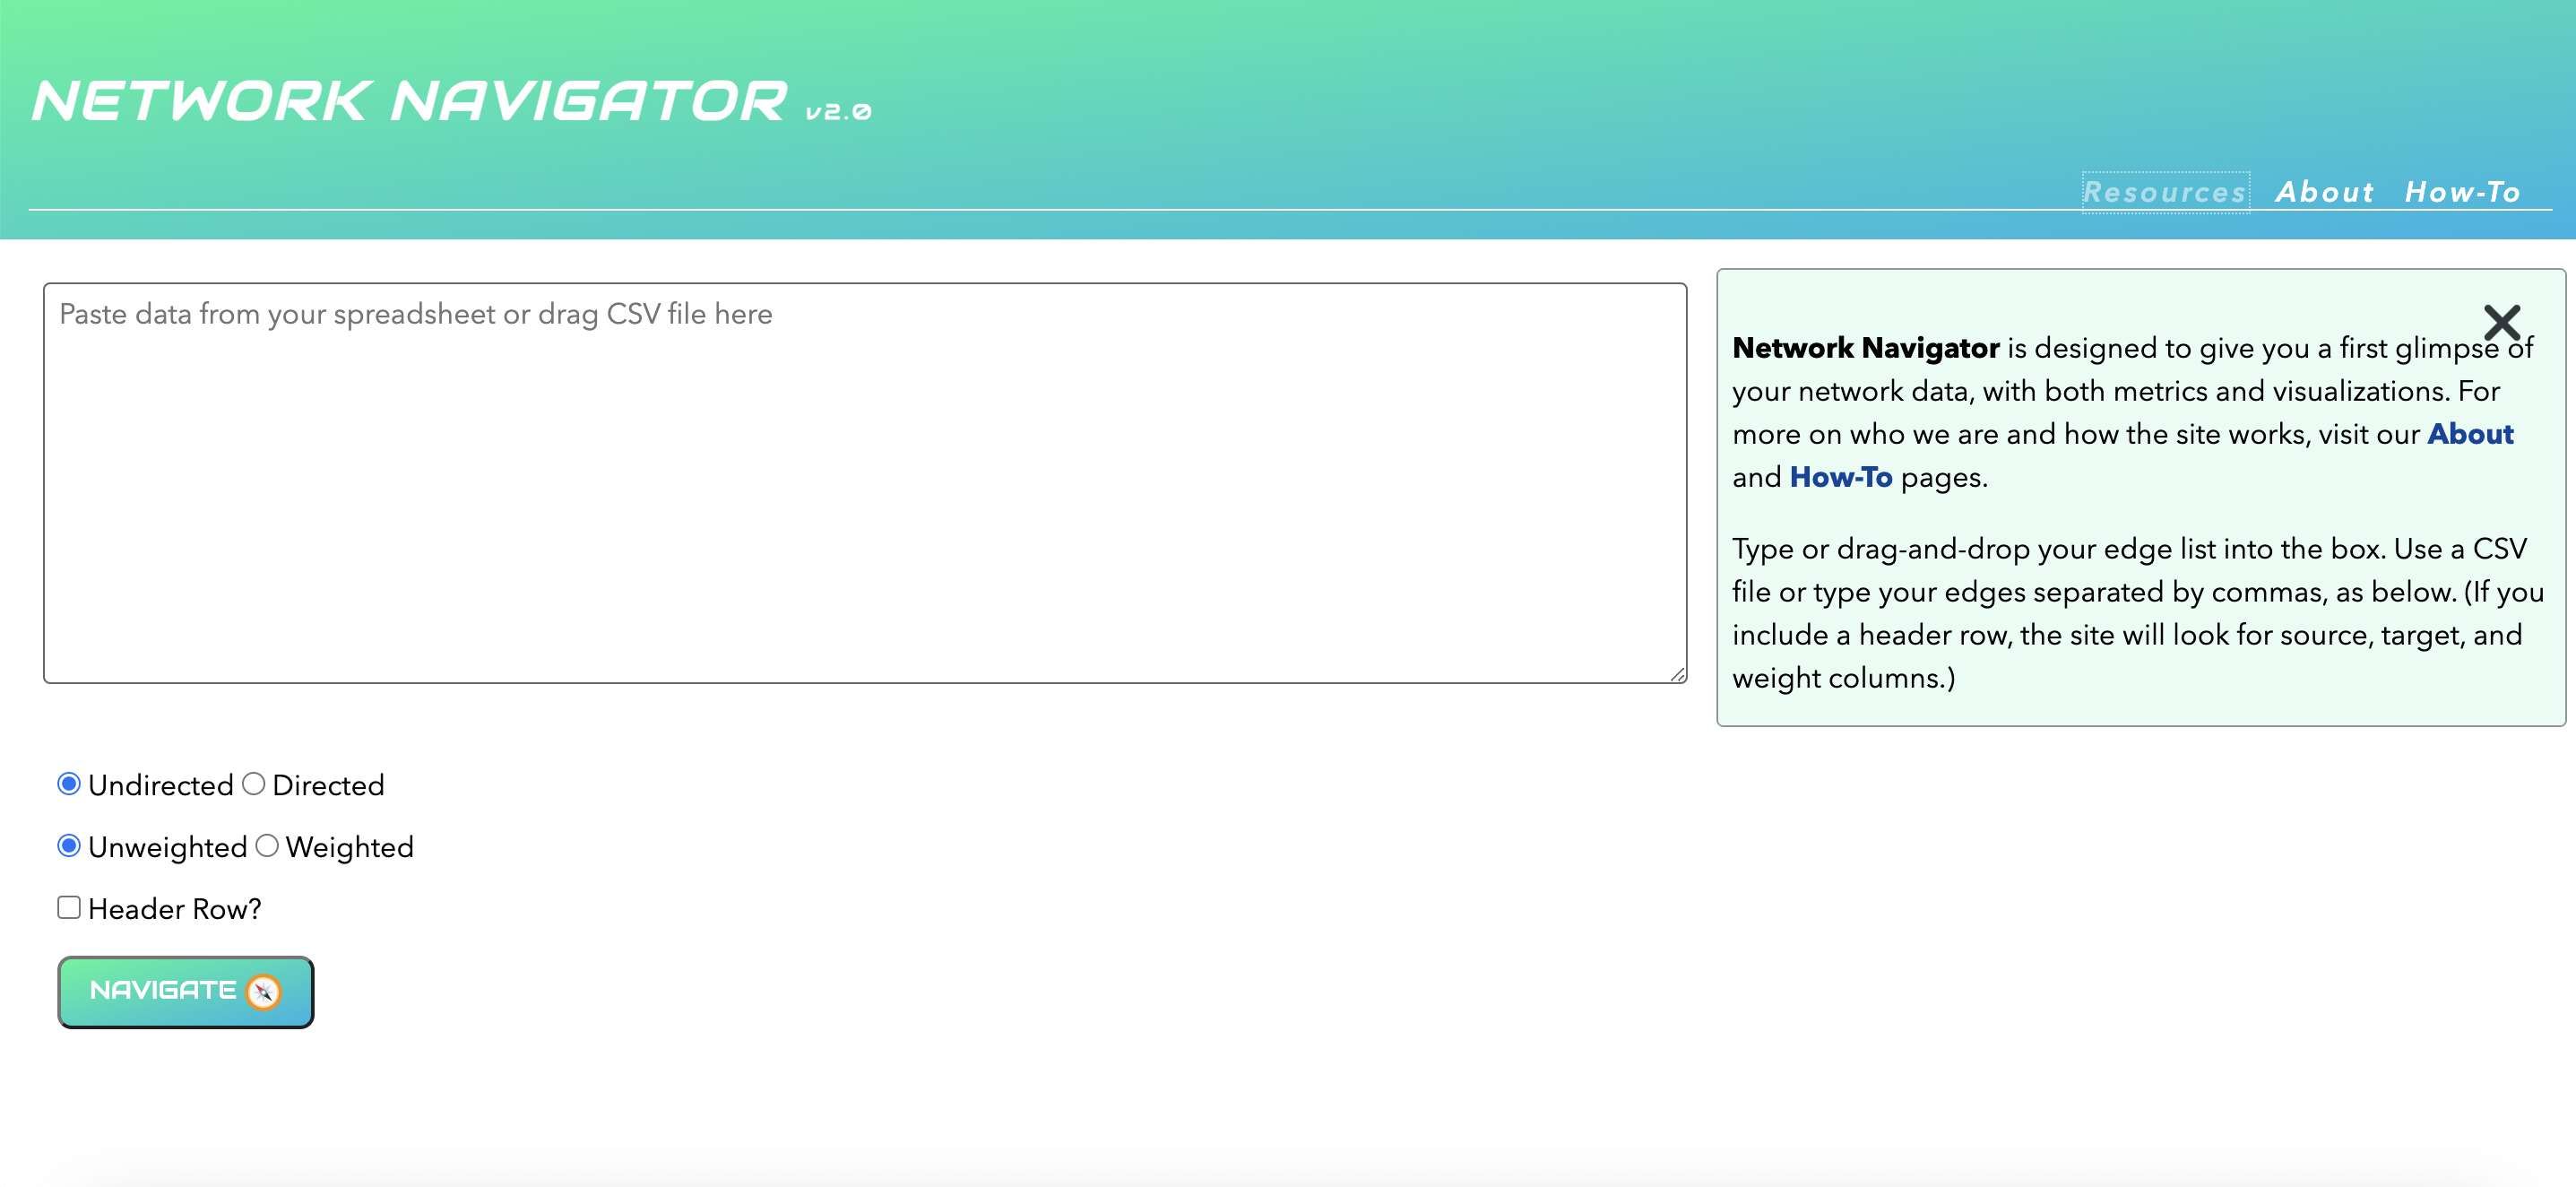

In [15]:
from IPython.display import Image 
metadata={
    "jdh": {
        "module": "object",
        "object": {
            "type":"image",
            "source": [
                "Current homepage of Network Navigator"
            ]
        }
    }
}
display(Image("media/nn_homepage.png"), metadata=metadata)

Such a layout is intended to be relatively straightforward for the user, and without many interactive features or pop-ups that have become widespread in web apps. But this design and layout is also a product of the longer history of the project.

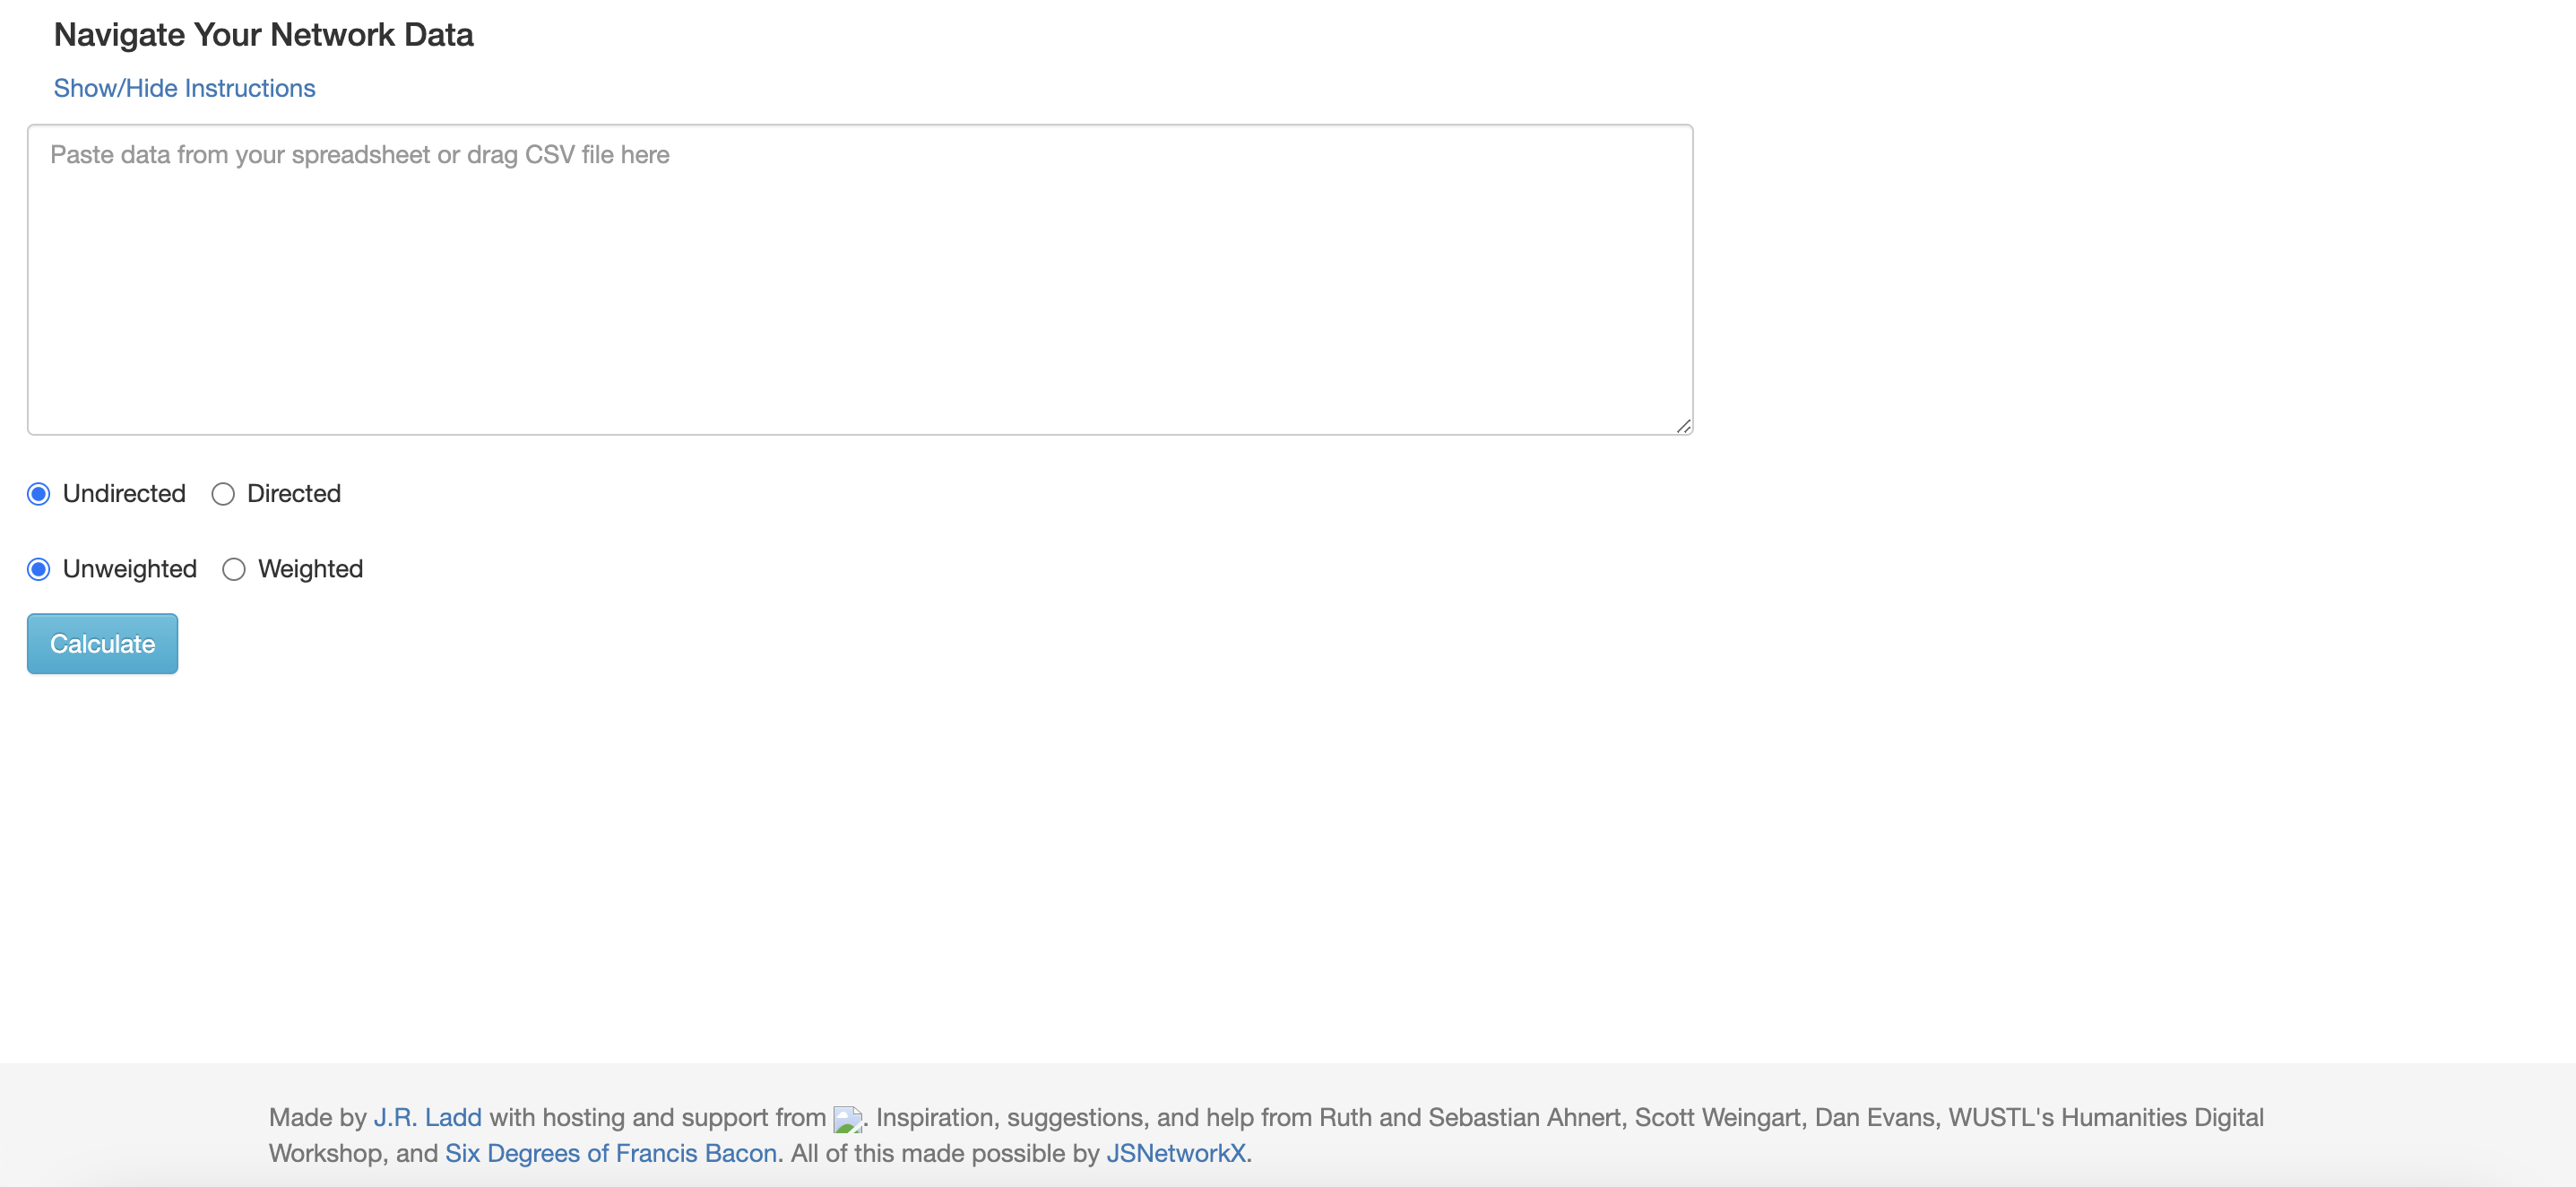

In [16]:
from IPython.display import Image 
metadata={
    "jdh": {
        "module": "object",
        "object": {
            "type":"image",
            "source": [
                "Original homepage of Network Navigator. Screenshot from https://web.archive.org/web/20190812053719/dh-web.hss.cmu.edu/network_navigator/"
            ]
        }
    }
}
display(Image("media/nn_original_homepage.png"), metadata=metadata)

Initially, *Network Navigator*  was simply a table. The imagined user would drag-and-drop network data into the browser and receive in return cleanly-formatted tabular data, detailing some standard network metrics. 

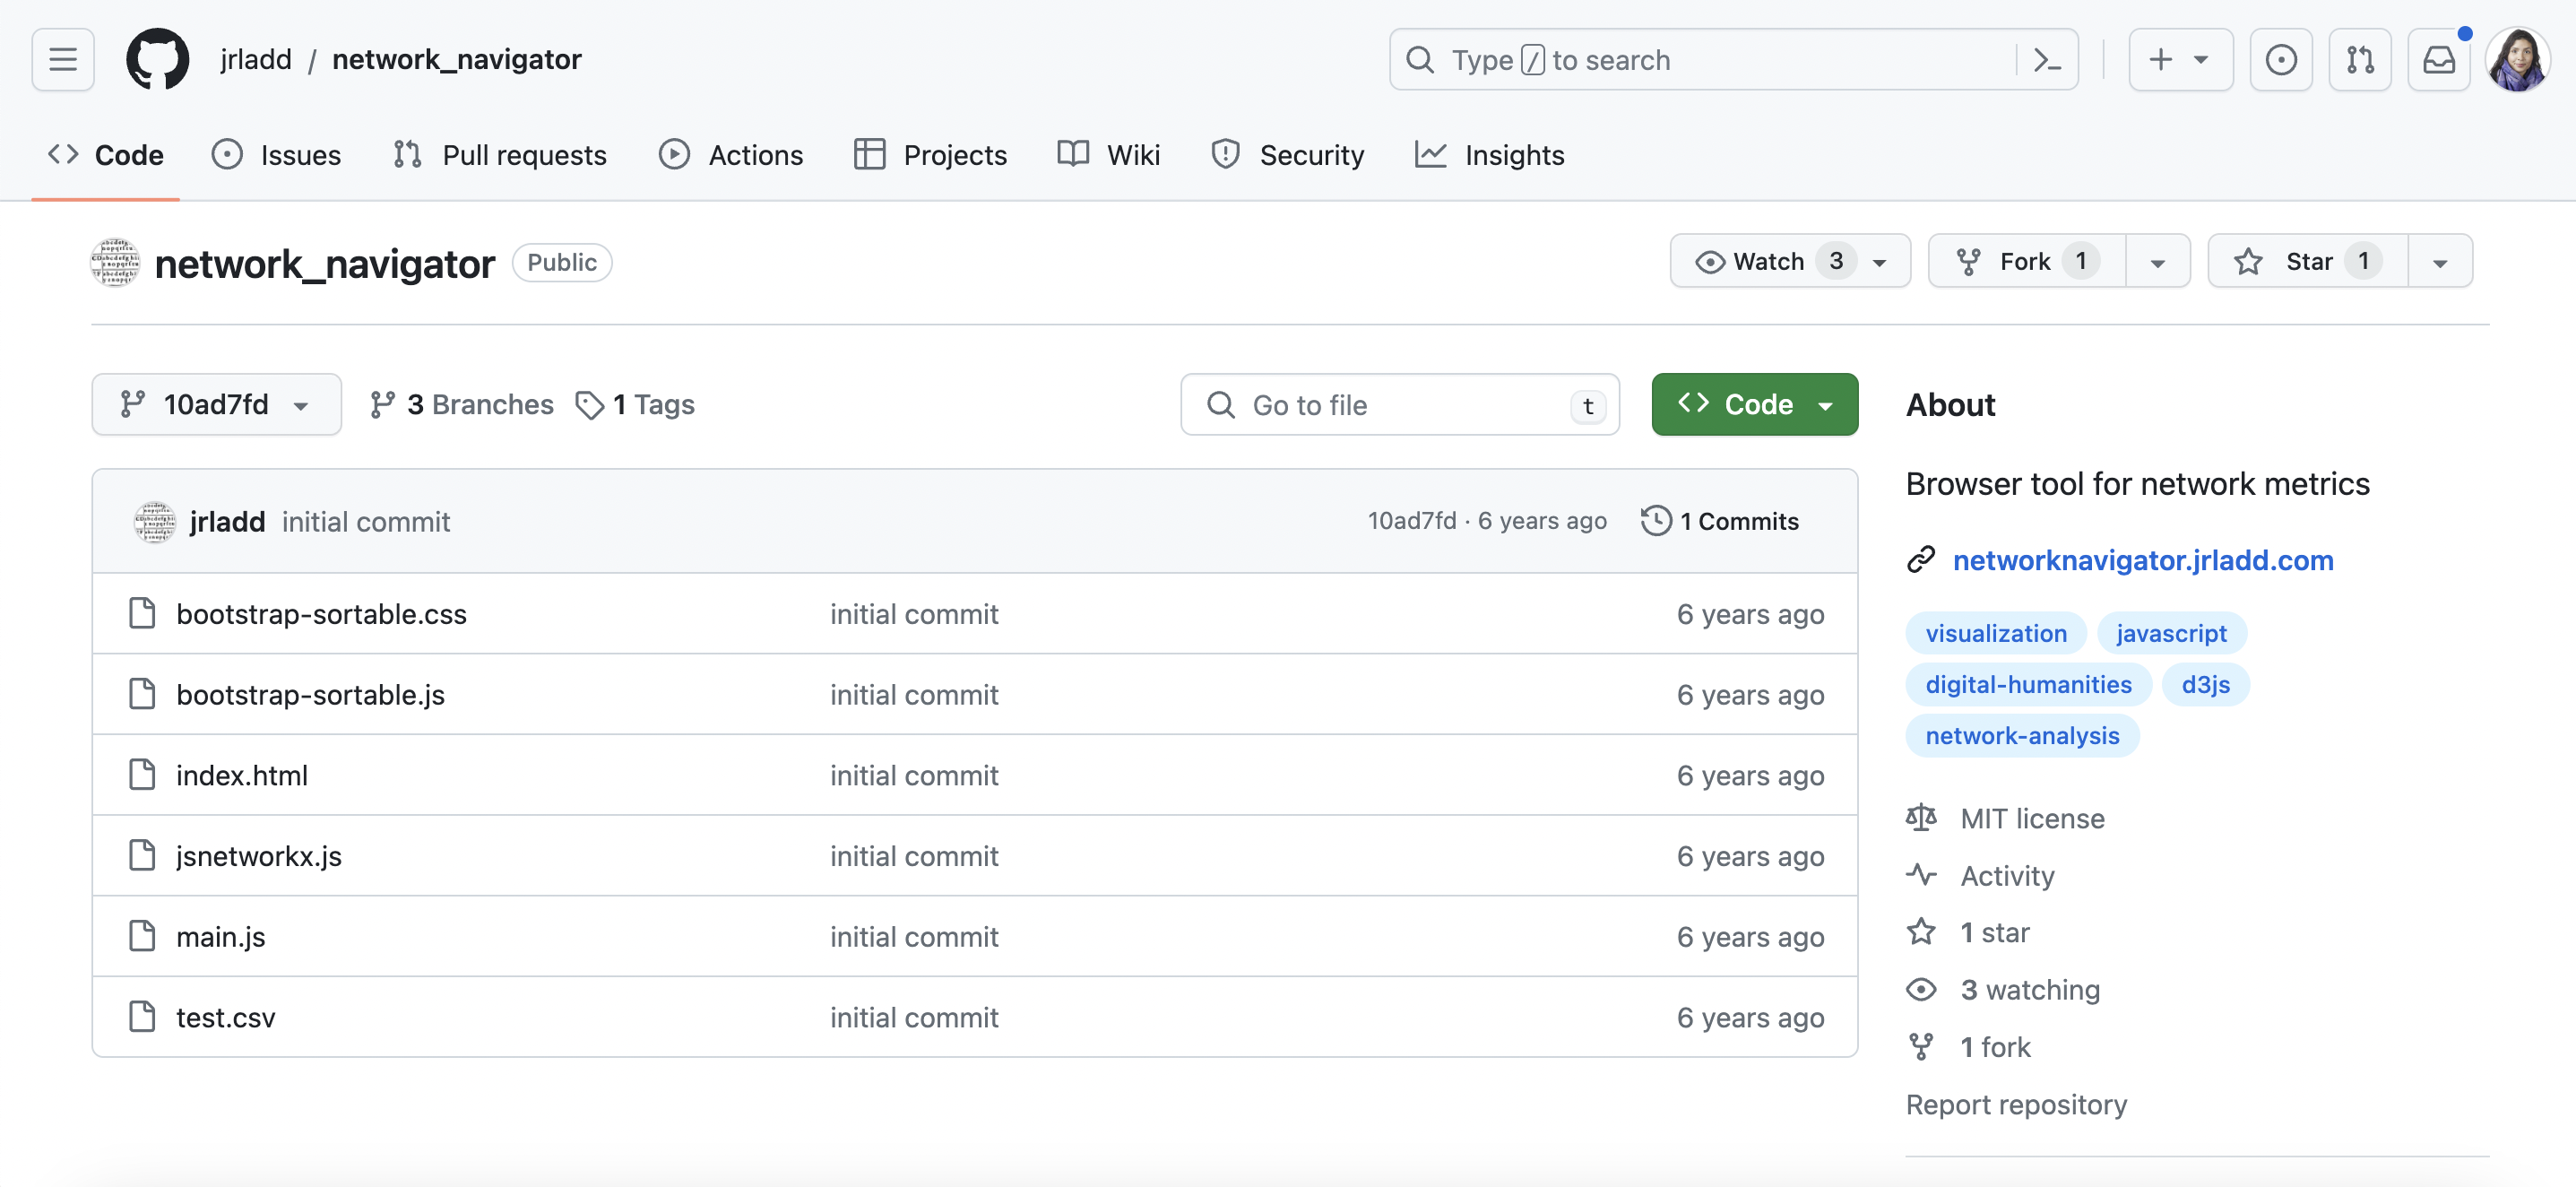

In [17]:
from IPython.display import Image 
metadata={
    "jdh": {
        "module": "object",
        "object": {
            "type":"image",
            "source": [
                "Original files in the Network Navigator GitHub Repository. First commit on August 8, 2017. Screenshot from https://github.com/jrladd/network_navigator/tree/10ad7fd45831980980d26bdacc2913a2fb1fb23c"
            ]
        }
    }
}
display(Image("media/nn_first_commit_repo.png"), metadata=metadata)

Ladd first created the GitHub repository for Network Navigator on August 8, 2017, and his first commit consisted of six files: a homepage through an index HTML file, an initial Javascript file to build networks, an example spreadsheet, and then imports from two libraries: JSNetworkx for the network analysis and the web design framework Bootstrap for styling of the website. The idea for the tool was born from Ladd’s contributions to the *Six Degrees of Francis Bacon* (SDFB) project, which visualized the social networks of early modern England in a crowdsourced web application. The SDFB site included many D3 visualizations for networks, drawing on a range of then-new visualization paradigms for networks in the humanities. However, the scope of that project and its design didn’t allow for some of the more advanced metrics Ladd was using internally for the project at the time, and he saw the possibilities for a web tool that could provide this functionality. Drawing from these experiences, Ladd built the first prototype of *Network Navigator* over the remainder of 2017, and while initially hosted via Ladd’s website and GitHub pages, in 2018, with assistance from Dan Evans, the tool was hosted by Carnegie Mellon University Libraries’ servers. 

Evans was succeeded in his role by Matt Lincoln, who contributed some fixes and oversaw the site while it was hosted at CMU, which is reflected in our earlier project history visualizations.

Beyond his experience on SDFB, one of the initial motivating factors for Ladd in creating *Network Navigator* was the desire to foreground network metrics, in response to humanists’ increasing interest in networks. This shift was also due to the emergence of Cultural Analytics and data science, where researchers were exploring the potential for networks not just as visualizations or databases but also applying network statistics and graph theory to study culture. At the time, only Gephi had these types of metrics–Palladio and other network analysis tools had none–and the metrics in Gephi were presented in a way that was often overwhelming, if not potentially dangerous, to novices. With a few clicks, users in Gephi could generate an enormous amount of statistical inferences about their networks, but these buttons included few explanations of how to interpret or understand these metrics. While scholars like Ben Schmidt have argued that humanists do not need to necessarily understand these algorithms, Ladd felt that similar to Rebecca Koeser’s assessment on the dangers of trusting others to do the math, tools like Gephi unintentionally made it difficult for humanists to understand the principles of network analysis, at times resulting in an over-interpretation of the visual features of graph layouts rather than engagement with network statistics.(<cite data-cite="14009734/IGWQ4G4A"></cite>,<cite data-cite="14009734/F4CEZB5A"></cite>) Therefore, *Network Navigator* initially combined a handful of the most popular introductory metrics in an interface that would help users learn how these metrics could inform their research questions, with the goal of helping the field move beyond networks as only a critical visualization practice towards what networks could tell us statistically and computationally. 

This core ethos has remained central to Network Navigator even as it was rebuilt by Ladd and LeBlanc, but before detailing their process, it is crucial to situate the tool within the longer history of DH tools and what Leigh Star and Karen Ruhleder termed an “ecology of infrastructure.”(<cite data-cite="14009734/WTEEPNWM"></cite>) Infrastructure, though a vast and sometimes nebulous concept—as anthropologist Brian Larkin notes, it can be “conceptually unruly”—is pivotal in understanding that digital tools transcend mere outputs.(<cite data-cite="14009734/B5F8YD4W"></cite>) Such an approach to studying these tools is in line with the recent rise of Critical Infrastructure Studies in DH, which seeks to bridge fields like Science and Technology Studies (STS) and Library and Information Sciences (LIS) with how we study the underlying systems and structures that support and shape DH research, tools, and methodologies. How Network Navigator constitutes infrastructure then is partially a question of its relation to both users and other existing network tools, which we explore later in this article. But it is also a helpful framework to contextualize the choices that shaped this tool within the longer trends and debates over DH tools, as Yrjö Engeström has argued, when studying a tool, we need to ask “when is a tool, rather than what is a tool”: in essence, not only exploring its functionality, but also its histories.(<cite data-cite="14009734/CF4Y7LDL"></cite>) 

To help understand the growing interest in DH tools and infrastructure, we can also explore these terms in DH academic writing. This approach is far from perfect, but can offer a helpful additional line of evidence to scholarly analysis for how these terms and the ideas they represent have evolved in DH. Using DH journals and other academic writings is an increasingly popular approach to study trends in the field, such as studies of the term theory in DH journals (<cite data-cite="14009734/KXLE6DED"></cite>) or using DH journal articles to situate it across disciplines (<cite data-cite="14009734/C9WX777B"></cite>).

To do this, we use the DH Conference Abstracts dataset from the *Index of DH Conferences*, the articles in *Digital Humanities Quarterly*, as well as data from DH journals that are available in the JSTOR Constellate platform, specifically *Computers and the Humanities* and *Languague Resources and Evaluation*. The choice of these journals is partially driven by what's available, but is also informed by growing research into which journals most represent DH.(<cite data-cite="14009734/CHCRP8EM"></cite>,<cite data-cite="14009734/MCSISMHQ"></cite>) 

In [18]:
terms = ['tool', 'tools', 'infrastructure']
tool_infrastructure_chart_output_path = f"{article_data_directory_path}/charts/tool_infrastructure_chart.json"
rerun_chart_code = True # Set to True to rerun the code to generate the charts

In [19]:
def process_jstor_data(df: pd.DataFrame, terms: List[str], date_column: str, id_column: str, origin_column: str, word_count_column: str, joined_term: Optional[str] = None) -> pd.DataFrame:
    """
    Process and group a DataFrame to calculate term frequencies.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    terms (List[str]): A list of terms for which to calculate frequencies.
    date_column (str): The name of the column in df that contains the date.
    id_column (str): The name of the column in df that contains the ID.
    origin_column (str): The name of the column in df that contains the origin of the data.
    word_count_column (str): The name of the column in df that contains the word count.
    joined_term (str, optional): A term that we've searched for in multiple formats that we want to normalize into one term. Defaults to None.

    Returns:
    final_grouped_df (pd.DataFrame): A DataFrame containing the terms and their frequencies, grouped by date and origin.
    """
    def process_counts(row):
        for term in terms:
            split_term = term.split()
            column_length = 'unigramCount' if len(split_term) == 1 else 'bigramCount' if len(split_term) == 2 else 'trigramCount'
            counts = row[column_length][term] if term in row[column_length] else 0
            row[term] = counts
        return row

    df = df.apply(process_counts, axis=1)

    subset_df = df[[date_column, id_column, origin_column, word_count_column] + terms]
    # If a tool column is provided, create the 'finalized_tool' column
    if joined_term:
        plural_joined_term = joined_term + "s"
        subset_df[f'finalized_{joined_term}'] = np.where(subset_df[joined_term].notnull(), subset_df[joined_term], subset_df[plural_joined_term])
        subset_df = subset_df.drop(columns=[joined_term, plural_joined_term])
        subset_df = subset_df.rename(columns={f"finalized_{joined_term}": joined_term})
    melted_df = pd.melt(subset_df, id_vars=[date_column, id_column, origin_column, word_count_column], var_name='terms', value_name='counts')
    melted_df['scaled_counts'] = melted_df['counts'] / melted_df[word_count_column]
    total_df = melted_df.groupby([origin_column, date_column])[word_count_column].sum().reset_index().rename(columns={word_count_column: 'total_tokens'})
    grouped_df = melted_df.groupby([origin_column, date_column, 'terms']).counts.sum().reset_index()
    scaled_grouped_df = melted_df.groupby([origin_column, date_column, 'terms']).scaled_counts.sum().reset_index()
    final_grouped_df = pd.merge(grouped_df, scaled_grouped_df, on=[origin_column, date_column, 'terms'])
    final_grouped_df = pd.merge(final_grouped_df, total_df, on=[origin_column, date_column])
    final_grouped_df.scaled_counts = final_grouped_df.scaled_counts * 100
    final_grouped_df = final_grouped_df.rename(columns={origin_column: 'data_origin', date_column: 'date'})
    final_grouped_df["title"] = final_grouped_df.data_origin

    return final_grouped_df

In [20]:
# Check if the chart file exists
if os.path.exists(tool_infrastructure_chart_output_path) and rerun_chart_code == False:
    # Load the chart from the JSON file
    with open(tool_infrastructure_chart_output_path) as json_file:
        infrastructure_tool_chart_dict = json.load(json_file)
    infrastructure_tool_chart = alt.Chart.from_dict(infrastructure_tool_chart_dict)
else:

    # Process the DataFrame to calculate term frequencies and tokenize text
    grouped_term_index_conferences_df = process_data(
        file_path=f"{original_data_directory_path}/dh_conferences_works.csv",
        text_column="full_text",
        date_column="conference_year",
        terms_list=terms,
        data_origin="Index of DH Conferences",
        title="Index of DH Conferences by Weingart et al (2023)",
        term_type="terms",
        term_mapping=False,
        joined_term="tool"
    )

    # Process the DataFrame to calculate term frequencies and tokenize text
    grouped_term_dhq_df = process_data(
        file_path=f"{original_data_directory_path}/private_data/dhq_data.csv",
        text_column="body_text",
        date_column="date_published",
        terms_list=terms,
        data_origin="DHQ",
        title="DHQ Articles (2023)",
        term_type="terms",
        term_mapping=False,
        joined_term="tool"
    )

    jstor_data = pd.read_json(f"{original_data_directory_path}private_data/jstor_data-jsonl.jsonl", lines=True)
    jstor_data['datePublished'] = pd.to_datetime(jstor_data['datePublished'])
    grouped_jstor_data = process_jstor_data(jstor_data, terms, 'datePublished', 'id', 'isPartOf', 'wordCount', joined_term='tool')

    term_combined_df = pd.concat([grouped_term_index_conferences_df, grouped_term_dhq_df, grouped_jstor_data])
    term_combined_df = term_combined_df.reset_index(drop=True)
    term_combined_df = term_combined_df.rename(columns={"counts": "Raw Frequency of Mentions", "scaled_counts": "Frequency of Mentions Scaled by Total Tokens"})

    term_combined_df.date = term_combined_df.date.astype(str)
    term_combined_df.date = term_combined_df.date.str.split(" ").str[0]
    term_combined_df['date'] = pd.to_datetime(term_combined_df.date, format='%Y-%m-%d')


    dropdown = alt.binding_select(
        options=['Raw Frequency of Mentions', 'Frequency of Mentions Scaled by Total Tokens'], 
        name='Select Counting Method on Y Axis'
    )
    ycol_param = alt.param(
        value="Raw Frequency of Mentions",
        bind=dropdown
    )

    infrastructure_term = term_combined_df[term_combined_df.terms == 'infrastructure']
    selection = alt.selection_point(fields=['data_origin'], bind='legend')
    infrastructure_chart = alt.Chart(infrastructure_term).mark_bar().encode(
        x=alt.X('year(date):T', axis=alt.Axis(title="Year")),
        y=alt.Y('y:Q', axis=alt.Axis(title="Frequency of Mentions")),
        color=alt.Color('data_origin:N', legend=alt.Legend(title="Data Origin", symbolLimit=0, labelLimit=0), scale=alt.Scale( scheme='tableau20'), sort=alt.EncodingSortField(field="counts", op="sum", order='descending')),
        tooltip=[
            alt.Tooltip('data_origin', title='Data Origin'),
            alt.Tooltip('Raw Frequency of Mentions'),
            alt.Tooltip('date:T', title='Date', format='%Y'),
            alt.Tooltip('Frequency of Mentions Scaled by Total Tokens'),
            alt.Tooltip('total_tokens', title='Total Tokens'),
        ],
        opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
    ).transform_calculate(
        y=f'datum[{ycol_param.name}]'
    ).add_params(
        ycol_param, selection
    ).properties(
        title="Popularity of the Term 'Infrastructure' Over Time and Across Multiple Datasets",
        width=500
    )

    tool_term = term_combined_df[term_combined_df.terms == 'tool']

    selection = alt.selection_point(fields=['data_origin'], bind='legend')

    tool_chart = alt.Chart(tool_term).mark_bar().encode(
        x=alt.X('year(date):T', axis=alt.Axis(title="Year")),
        y=alt.Y('y:Q', axis=alt.Axis(title="Frequency of Mentions")),
        color=alt.Color('data_origin:N', legend=alt.Legend(title="Data Origin", symbolLimit=0, labelLimit=0), scale=alt.Scale( scheme='tableau20'), sort=alt.EncodingSortField(field="counts", op="sum", order='descending')),
        tooltip=[
            alt.Tooltip('data_origin', title='Data Origin'),
            alt.Tooltip('Raw Frequency of Mentions'),
            alt.Tooltip('date:T', title='Date', format='%Y'),
            alt.Tooltip('Frequency of Mentions Scaled by Total Tokens'),
            alt.Tooltip('total_tokens', title='Total Tokens'),
        ],
        opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
    ).transform_calculate(
        y=f'datum[{ycol_param.name}]'
    ).add_params(
        ycol_param, selection
    ).properties(
        title=f"Popularity of the Term 'Tool' Over Time and Across Multiple Datasets",
        width=500
    )

    infrastructure_tool_chart = alt.vconcat(infrastructure_chart, tool_chart).configure(
        title=alt.TitleConfig(fontSize=20, font='Garamond', anchor='middle'),
        axis=alt.AxisConfig(labelFont='Garamond', titleFont='Garamond'),
        legend=alt.LegendConfig(labelFont='Garamond', titleFont='Garamond')
    )
    infrastructure_tool_chart.save(tool_infrastructure_chart_output_path)

infrastructure_tool_chart


        

alt.VConcatChart(...)

While histories of DH have started to proliferate in the last two decades, there remain few that foreground individual tools or methodologies, though certainly scholars like Julia Nyhan and Melissa Terras have recovered parts of this history, whether through complicating our histories of Robert Busa’s concordance programs or tracing the careers of the first DH developers, like John Bradley who started developing tools for text analysis in the 1970s.(<cite data-cite="14009734/IVAWRTNG"></cite>,<cite data-cite="14009734/WJCHZWBW"></cite>) If we primarily focus then on tools, unsurprisingly we find that the advent of mass digitization and the web in the 1990s and early 2000s was a moment of intense debate over tools (as indicated in our visualizations). Indeed, in 2003, John Unsworth, reflecting on the last decade of humanities computing, questioned whether the field was “going around in circles” because of the consistent refrain for needing better tools for humanities research.(<cite data-cite="14009734/DVU3K8KC"></cite>) To overcome these obstacles, Unsworth proposed the framing of ‘scholarly primitives’ to elucidate the theoretical and shared functions that undergird humanities research “that could be the basis for a manageable but also useful tool-building enterprise in humanities computing.” Part of Unsworth’s primitives was trying to envision the potential of DH tools, but it was also intended to argue for the necessity of these tools: both to grant funders and especially to skeptical humanists.(<cite data-cite="14009734/BNUZH96S"></cite>) Such a focus was also central to the 2006 Summit on Digital Tools for the Humanities, also chaired by Unsworth, which argued “that only about six percent of humanist scholars go beyond general purpose information technology and use digital resources and more complex digital tools in their scholarship.”(<cite data-cite="14009734/8DC6SYTG"></cite>) This claim was further supported by Patrick Juola, who through citation analysis showed that very few high profile humanists had published or even engaged with humanities computing, though journals like Computers and the Humanities had been in print since the 1960s. This lack of engagement, especially given the growing abundance of born digital and digitized materials, led many to conclude that most DH tools were too bespoke for the average humanist, and that the solution was to focus on creating shared, large-scale infrastructure, or what Juola termed a “Killer App.”(<cite data-cite="14009734/EFPWW7BX"></cite>) Realizing this dream of wide-spread uptake of DH tools was also often tied to calls for standardizing tool infrastructures that was partially realized in projects like TEI and the maturing of web technologies.(<cite data-cite="14009734/62M584MJ"></cite>) But even without these shared standards or killer apps, this sense that large scale software development as the solution was undoubtedly influential in the development of tools like Zotero and Voyant Tools, along with network analysis tools like Gephi, whose developers described being “inspired by WYSIWYG editors like Adobe Photoshop.”(<cite data-cite="14009734/ZU6QXVNL"></cite>)

However, Gephi itself was not initially conceived of or built as primarily a tool for digital humanities research. According to Clément Levallois, the idea for Gephi was first developed in 2006 by Mathieu Jacomy, as part of his work with the e-Diasporas Atlas project and, and by Eytan Adar, as part of his work on GUESS, the Graph Exploration System Software.(<cite data-cite="14009734/K5C75JVX"></cite>) Together with researchers from Université Technologique de Compiègne, the team worked on developing the initial version of Gephi, releasing it for download on September 8, 2008, and then making the software public on GitHub on March 2, 2009. Part of the impetus for Gephi, according to one of the developers Sebastien Heymann, was that “other network visualization software is either a poor visualization module or a stunning aspect but not efficient.” For example, one of the earliest network analysis tools, Pajek, first released in 1997, would only let you visualize a few hundred nodes, and GUESS, released in 2007, could only display up to 2000 nodes. Thus, the creators of Gephi initially focused on leveraging new graphical technologies like GPUs to render much larger networks; the initial release could do up to 50000 nodes.(<cite data-cite="14009734/DGNAHYY3"></cite>) But the very existence of this software was also indicative of the massive growth of network science as a field during this period. As the authors of The Network Turn have argued, the 1998 publication “Collective Dynamics of Small World Networks” by Duncan J. Watts and Steven Strogatz and the 1999 publication “Emergence of Scaling in Random Networks” by Albert-László Barabási and Réka Albert “ushered in the field of network science,” in many ways parallel to the coterminous growth of digital humanities.(<cite data-cite="undefined"></cite>) And yet, much of this initial debate over DH tools was focused almost exclusively on tools for working with digitized texts (whether editing and annotating or analyzing them). 

To see more on the history of Gephi, we also explored the early commit history https://github.com/gephi/gephi/commit/c1a1b8316427b1e5c6e0ea5ea8031a016b7ba2c1 and web archived versions of their website https://web.archive.org/web/20080912001706/https://gephi.org/ .

In [21]:
terms = ['network', 'networks', 'network analysis']
network_analysis_chart_output_path = f"{article_data_directory_path}/charts/network_analysis_chart.json"
rerun_chart_code = True # Set to True to rerun the code to generate the charts

In [22]:
# Check if the chart file exists
if os.path.exists(network_analysis_chart_output_path) and rerun_chart_code == False:
    # Load the chart from the JSON file
    with open(network_analysis_chart_output_path) as json_file:
        network_analysis_chart_dict = json.load(json_file)
    network_analysis_chart = alt.Chart.from_dict(network_analysis_chart_dict)
else:

    # Process the DataFrame to calculate term frequencies and tokenize text
    grouped_term_index_conferences_df = process_data(
        file_path=f"{original_data_directory_path}/dh_conferences_works.csv",
        text_column="full_text",
        date_column="conference_year",
        terms_list=terms,
        data_origin="Index of DH Conferences",
        title="Index of DH Conferences by Weingart et al (2023)",
        term_type="terms",
        term_mapping=False,
        joined_term="network"
    )

    # Process the DataFrame to calculate term frequencies and tokenize text
    grouped_term_dhq_df = process_data(
        file_path=f"{original_data_directory_path}/private_data/dhq_data.csv",
        text_column="body_text",
        date_column="date_published",
        terms_list=terms,
        data_origin="DHQ",
        title="DHQ Articles (2023)",
        term_type="terms",
        term_mapping=False,
        joined_term="network"
    )

    jstor_data = pd.read_json(f"{original_data_directory_path}private_data/jstor_data-jsonl.jsonl", lines=True)
    jstor_data['datePublished'] = pd.to_datetime(jstor_data['datePublished'])
    grouped_jstor_data = process_jstor_data(jstor_data, terms, 'datePublished', 'id', 'isPartOf', 'wordCount', joined_term='network')

    term_combined_df = pd.concat([grouped_term_index_conferences_df, grouped_term_dhq_df, grouped_jstor_data])
    term_combined_df = term_combined_df.reset_index(drop=True)
    term_combined_df = term_combined_df.rename(columns={"counts": "Raw Frequency of Mentions", "scaled_counts": "Frequency of Mentions Scaled by Total Tokens"})

    term_combined_df.date = term_combined_df.date.astype(str)
    term_combined_df.date = term_combined_df.date.str.split(" ").str[0]
    term_combined_df['date'] = pd.to_datetime(term_combined_df.date, format='%Y-%m-%d')


    dropdown = alt.binding_select(
        options=['Raw Frequency of Mentions', 'Frequency of Mentions Scaled by Total Tokens'], 
        name='Select Counting Method on Y Axis'
    )
    ycol_param = alt.param(
        value="Raw Frequency of Mentions",
        bind=dropdown
    )

    network_term = term_combined_df[term_combined_df.terms == 'network']
    selection = alt.selection_point(fields=['data_origin'], bind='legend')
    network_chart = alt.Chart(network_term).mark_bar().encode(
        x=alt.X('year(date):T', axis=alt.Axis(title="Year")),
        y=alt.Y('y:Q', axis=alt.Axis(title="Frequency of Mentions")),
        color=alt.Color('data_origin:N', legend=alt.Legend(title="Data Origin", symbolLimit=0, labelLimit=0), scale=alt.Scale( scheme='tableau20'), sort=alt.EncodingSortField(field="counts", op="sum", order='descending')),
        tooltip=[
            alt.Tooltip('data_origin', title='Data Origin'),
            alt.Tooltip('Raw Frequency of Mentions'),
            alt.Tooltip('date:T', title='Date', format='%Y'),
            alt.Tooltip('Frequency of Mentions Scaled by Total Tokens'),
            alt.Tooltip('total_tokens', title='Total Tokens'),
        ],
        opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
    ).transform_calculate(
        y=f'datum[{ycol_param.name}]'
    ).add_params(
        ycol_param, selection
    ).properties(
        title="Popularity of the Term 'Network' Over Time and Across Multiple Datasets",
        width=500
    )

    network_analysis_term = term_combined_df[term_combined_df.terms == 'network analysis']

    selection = alt.selection_point(fields=['data_origin'], bind='legend')

    network_analysis_chart = alt.Chart(network_analysis_term).mark_bar().encode(
        x=alt.X('year(date):T', axis=alt.Axis(title="Year")),
        y=alt.Y('y:Q', axis=alt.Axis(title="Frequency of Mentions")),
        color=alt.Color('data_origin:N', legend=alt.Legend(title="Data Origin", symbolLimit=0, labelLimit=0), scale=alt.Scale( scheme='tableau20'), sort=alt.EncodingSortField(field="counts", op="sum", order='descending')),
        tooltip=[
            alt.Tooltip('data_origin', title='Data Origin'),
            alt.Tooltip('Raw Frequency of Mentions'),
            alt.Tooltip('date:T', title='Date', format='%Y'),
            alt.Tooltip('Frequency of Mentions Scaled by Total Tokens'),
            alt.Tooltip('total_tokens', title='Total Tokens'),
        ],
        opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
    ).transform_calculate(
        y=f'datum[{ycol_param.name}]'
    ).add_params(
        ycol_param, selection
    ).properties(
        title=f"Popularity of the Term 'Network Analysis' Over Time and Across Multiple Datasets",
        width=500
    )

    network_analysis_chart = alt.vconcat(network_chart, network_analysis_chart).configure(
        title=alt.TitleConfig(fontSize=20, font='Garamond', anchor='middle'),
        axis=alt.AxisConfig(labelFont='Garamond', titleFont='Garamond'),
        legend=alt.LegendConfig(labelFont='Garamond', titleFont='Garamond')
    )
    network_analysis_chart.save(network_analysis_chart_output_path)

network_analysis_chart

alt.VConcatChart(...)

Since then, tools for network analysis, like Gephi, have become wildly popular in the field, as we visualized at the outset. But we believe that part of this shift is not only the availability of these tools, but also the shift in how DH as a field approaches these tools, both in terms of making and theorizing them, and that understanding these shifts is critical for contextualizing Network Navigator.

To understand the growth then of network analysis tools, we need to return to the aftermath of the 2006 Summit on DH Tools, where one of the main takeaways was that these digital tools needed further theorizing to uncover why they were not being more widely adopted or why more were not being built in the first place. To that end, Susan Schreibman and Ann Hanlon completed the first survey of DH tool developers in 2008 to understand how the creators of these tools conceived of their efforts. While the survey focused on a mix of “branded” and “unbranded” DH tools, the main finding was that “overwhelming majority of respondents (94%) considered tool development a scholarly activity, although the range of responses to this question made it clear that many departments and institutions do not.” Part of the solution to this disconnect was increased advocacy on evaluating and crediting digital scholarship through scholarly associations like the MLA and AHA, but there was also a growing debate over whether tools should be considered not just scholarship, but also as theoretical objects into themselves.

For DH developers like John Bradley, there was a sense that “in early discussions on the Humanist discussion list (for example in the late 1980s and early 1990s), the term ‘tool’ often carried a pejorative tone, with the implication of considering something as ‘merely.”(<cite data-cite="14009734/VSVHNBCB"></cite>) But the proliferation of new digital tools led scholars like Willard McCarty in a Humanist exchange to question whether “digital artifacts” could be interpreted without some paratextual explanation: in essence, could digital tools function as other forms of scholarly objects or were they simply a means to an end. Stephen Ramsay and Geoffrey Rockwell sought to directly answer this question, arguing that if building functioned similarly to writing technologies, then “the quality of the interventions that occur as a result of building are as interesting as those that are typically established through writing, then that activity is, for all intents and purposes, scholarship.”(<cite data-cite="14009734/NPX9J9CR"></cite>) Ramsay had proposed a similar assessment earlier in 2011 at the MLA arguing for building and making as “a new kind of hermeneutic,” though his assertion became somewhat overshadowed by his framing of defining who ‘counted’ as a digital humanist.(<cite data-cite="14009734/C5XIWTIJ">)</cite> But even before what eventually became the “hack versus yack” debates, there was growing awareness but also anxiety over digital tools, as Julia Flanders articulated, “Digital tools add a challenge and give us a new set of terms — like a new planet in the system, they change the vectors of all the other things we have in our universe. They will probably change the way humanities research is done.”(<cite data-cite="14009734/U5S5QBGA"></cite>)

Assessing this “new planet” of digital tools then would require not only new forms of credit for creating tools, but also the development of new scholarly infrastructure and frameworks that centered tools as objects of study. Part of this transformation was evidenced in growing calls for peer review of these tools. Initially advocated by Alan Galey and Stan Ruecker who, building from Lev Manovich’s response to McCarthy that “a prototype is a theory”, proposed that prototypes should be peer reviewed like other forms of scholarship. For Galey and Ruecker, prototypes were a capacious category that included tools, along with many ‘digital objects.’ But regardless of terminology, the authors argued that peer reviewing would serve as a “useful bridge between the tool-building tradition of the digital humanities on one hand, and interpretive and critical traditions like book history and science and technology studies on the other,” helping move tools from being seen as service-based outputs towards inquiry-based ones.(<cite data-cite="14009734/R3YCV5WX"></cite>) The necessity of such peer review mechanisms was further reinforced by Annie Swafford with her analysis of Matthew Jockers’ sentiment analysis library “Syuzhet,” which eventually became the subject of a protracted Twitter debate over the assumptions built into the tool, something Swafford felt that formal peer review would have been better suited to resolving. To avoid future Syuzhet debates and to realize Galey and Ruecker’s vision, many academic journals have increasingly developed mechanisms for reviewing digital projects and even tools.(<cite data-cite="14009734/KGFN5ATC"></cite>) But even more profound has been the development of more robust theoretical frameworks for analyzing tools that not only detail the functionalities of these tools, but also explore the socio-political assumptions built into these tools.

In [23]:
terms = ['tool criticism', 'algorithmic criticism']
tool_algo_criticism_chart_output_path = f"{article_data_directory_path}/charts/tool_algo_criticism_chart.json"
rerun_chart_code = True # Set to True to rerun the code to generate the charts

In [24]:
# Check if the chart file exists
if os.path.exists(tool_algo_criticism_chart_output_path) and rerun_chart_code == False:
    # Load the chart from the JSON file
    with open(tool_algo_criticism_chart_output_path) as json_file:
        tool_algo_criticism_chart_dict = json.load(json_file)
    tool_algo_criticism_chart = alt.Chart.from_dict(tool_algo_criticism_chart_dict)
else:

    # Process the DataFrame to calculate term frequencies and tokenize text
    grouped_term_index_conferences_df = process_data(
        file_path=f"{original_data_directory_path}/dh_conferences_works.csv",
        text_column="full_text",
        date_column="conference_year",
        terms_list=terms,
        data_origin="Index of DH Conferences",
        title="Index of DH Conferences by Weingart et al (2023)",
        term_type="terms",
        term_mapping=False,
        joined_term=None
    )

    # Process the DataFrame to calculate term frequencies and tokenize text
    grouped_term_dhq_df = process_data(
        file_path=f"{original_data_directory_path}/private_data/dhq_data.csv",
        text_column="body_text",
        date_column="date_published",
        terms_list=terms,
        data_origin="DHQ",
        title="DHQ Articles (2023)",
        term_type="terms",
        term_mapping=False,
        joined_term=None
    )

    jstor_data = pd.read_json(f"{original_data_directory_path}private_data/jstor_data-jsonl.jsonl", lines=True)
    jstor_data['datePublished'] = pd.to_datetime(jstor_data['datePublished'])
    grouped_jstor_data = process_jstor_data(jstor_data, terms, 'datePublished', 'id', 'isPartOf', 'wordCount', joined_term=None)

    term_combined_df = pd.concat([grouped_term_index_conferences_df, grouped_term_dhq_df, grouped_jstor_data])
    term_combined_df = term_combined_df.reset_index(drop=True)
    term_combined_df = term_combined_df.rename(columns={"counts": "Raw Frequency of Mentions", "scaled_counts": "Frequency of Mentions Scaled by Total Tokens"})

    term_combined_df.date = term_combined_df.date.astype(str)
    term_combined_df.date = term_combined_df.date.str.split(" ").str[0]
    term_combined_df['date'] = pd.to_datetime(term_combined_df.date, format='%Y-%m-%d')


    dropdown = alt.binding_select(
        options=['Raw Frequency of Mentions', 'Frequency of Mentions Scaled by Total Tokens'], 
        name='Select Counting Method on Y Axis'
    )
    ycol_param = alt.param(
        value="Raw Frequency of Mentions",
        bind=dropdown
    )

    tool_criticism_term = term_combined_df[term_combined_df.terms == 'tool criticism']
    selection = alt.selection_point(fields=['data_origin'], bind='legend')
    tool_criticism_chart = alt.Chart(tool_criticism_term).mark_bar().encode(
        x=alt.X('year(date):T', axis=alt.Axis(title="Year")),
        y=alt.Y('y:Q', axis=alt.Axis(title="Frequency of Mentions")),
        color=alt.Color('data_origin:N', legend=alt.Legend(title="Data Origin", symbolLimit=0, labelLimit=0), scale=alt.Scale( scheme='tableau20'), sort=alt.EncodingSortField(field="counts", op="sum", order='descending')),
        tooltip=[
            alt.Tooltip('data_origin', title='Data Origin'),
            alt.Tooltip('Raw Frequency of Mentions'),
            alt.Tooltip('date:T', title='Date', format='%Y'),
            alt.Tooltip('Frequency of Mentions Scaled by Total Tokens'),
            alt.Tooltip('total_tokens', title='Total Tokens'),
        ],
        opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
    ).transform_calculate(
        y=f'datum[{ycol_param.name}]'
    ).add_params(
        ycol_param, selection
    ).properties(
        title="Popularity of the Term 'Tool Criticism' Over Time and Across Multiple Datasets",
        width=500
    )

    algorithmic_criticism_term = term_combined_df[term_combined_df.terms == 'algorithmic criticism']

    selection = alt.selection_point(fields=['data_origin'], bind='legend')

    algorithmic_criticism_chart = alt.Chart(algorithmic_criticism_term).mark_bar().encode(
        x=alt.X('year(date):T', axis=alt.Axis(title="Year")),
        y=alt.Y('y:Q', axis=alt.Axis(title="Frequency of Mentions")),
        color=alt.Color('data_origin:N', legend=alt.Legend(title="Data Origin", symbolLimit=0, labelLimit=0), scale=alt.Scale( scheme='tableau20'), sort=alt.EncodingSortField(field="counts", op="sum", order='descending')),
        tooltip=[
            alt.Tooltip('data_origin', title='Data Origin'),
            alt.Tooltip('Raw Frequency of Mentions'),
            alt.Tooltip('date:T', title='Date', format='%Y'),
            alt.Tooltip('Frequency of Mentions Scaled by Total Tokens'),
            alt.Tooltip('total_tokens', title='Total Tokens'),
        ],
        opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
    ).transform_calculate(
        y=f'datum[{ycol_param.name}]'
    ).add_params(
        ycol_param, selection
    ).properties(
        title=f"Popularity of the Term 'Algorithmic Criticism' Over Time and Across Multiple Datasets",
        width=500
    )

    tool_algo_criticism_chart = alt.vconcat(tool_criticism_chart, algorithmic_criticism_chart).configure(
        title=alt.TitleConfig(fontSize=20, font='Garamond', anchor='middle'),
        axis=alt.AxisConfig(labelFont='Garamond', titleFont='Garamond'),
        legend=alt.LegendConfig(labelFont='Garamond', titleFont='Garamond')
    )
    tool_algo_criticism_chart.save(tool_algo_criticism_chart_output_path)

tool_algo_criticism_chart

alt.VConcatChart(...)

The most prominent framework to this end has been the concept of “tool criticism”, which was inspired by earlier work on digital source criticism and algorithmic criticism, as well as the emergence of Critical Code Studies and Software Studies both of which treat code as an object for scholarship. As far as we have been able to determine, the first call for this type of work was in a Master’s thesis by Anastasia Dorofeeva titled “Towards Digital Humanities Tool Criticism” published in 2014 from the University of Leiden.(<cite data-cite="14009734/6HWILXZU"></cite>) Since then, the concept has quickly become popular as a methodology that reflexively attends to both the technical and socio-political nature of DH tools. In defining this approach, Karin Van Es, Maranke Wieringa, and Mirko Tobias Schäfer argue that it not only embodies a critical approach to computation, like the ones advocated by CCS scholars like David M. Berry, but also “incorporates reflection on the interaction between the researcher and the tool” and at the same time collapses “distinction of tool builder and researcher.”(<cite data-cite="14009734/32WND4AE"></cite>)

In the case of *Network Navigator*, tool criticism has been particularly helpful for reflecting on our design and development choices, though we were not directly familiar with it when building *Network Navigator*. But tool criticism is also broadly relevant since many scholars have focused on Gephi and network analysis as a case study for this framework. For example, Van Es et al utilize tool criticism to critically theorize Gephi’s popularity and also elucidate its constraints, such as the ways in which the tool “gives a large audience the ability to produce network diagrams without understanding the ‘layers of mediation’ involved in its production.” To help make these layers visible, the authors detail creating the “Gephi field notes plugin,” which takes snapshots of a network in Gephi, along with the transformations required to create it and saves it as a text file.(<cite data-cite="undefined"></cite>) In many ways, the creation of this plugin corresponds with our desire to create *Network Navigator*, as attempts to intervene in scholarly practices. And similarly, both our projects also build from Johanna Drucker and Patrick Svensson’s concept of “middleware.” Though the concept of middleware is somewhat more narrow than tool criticism, in a 2016 DHQ article, Drucker and Svensson argued that greater scholarly attention was needed to uncover how software (whether tools or platforms) shape scholarly arguments. The authors highlighted the example of Gephi diagrams, describing how the popularity of force-layout diagrams elide over how these visualizations are “not a natural expression of structured data, it is instead a distinct expression in a system authored by a programmer responsible for the coming-into-being of that visual form in a precise form.”(<cite data-cite="14009734/FVU9I7DB"></cite>) More recent work has continued to theorize Gephi through the lens of tool criticism, including work by Daniela Van Geenen, who has published two recent articles (the second of which includes some of the lead developers of Gephi). In the first, she uses tool criticism, along with the framing of “epistemological affordances,” to explore how Gephi’s interface and documentation enables users to follow the progression of their work and scrutinize the methods applied within the tool. Of particular concern to Van Geenen is how Gephi limits “reversibility and reproducibility,” and she argues that the lack of undo or redo functionality undermines any algorithmic accountability or critical use of Gephi.(<cite data-cite="14009734/2RG8L9PE"></cite>) While we agree with Van Geenen on the importance of understanding these algorithms, building this proposed undo/redo functionality for any network algorithm would require significant computational resources, which is why we have not included such features in *Network Navigator*. Nonetheless, we believe that our tool shares a similar core ethos to this scholarship; in essence, the belief that these tools should promote a critical technical practice that goes beyond mere tool functionality and considers the diverse uses of networks across and beyond scholarly communities. Which is why in our development of *Network Navigator* we have focused primarily on DH pedagogical needs, but have also been inspired by growing critiques of large scale infrastructure for DH research.

Though both Ladd and LeBlanc had previous experience building complex web applications, as mentioned previously *Network Navigator* is largely composed of foundational web technologies: HTML, CSS, and Javascript. Such a relatively simple technological stack is in contrast to tools like Gephi or Voyant Tools, both of which are built in Java with far more complex design patterns and architecture. But while our technical choices diverge from other DH tools, we are far from the first to consider privileging less as more. As early as 2012, scholars like Joris Van Zundert were arguing that “big institutionally-based digital infrastructures are a dead end for information technology development and application in the humanities.” While Van Zundert was critiquing proposals like the ones for Killer Apps, his assessments on the difficulties, if not outright impossibility, of building widely generalizable tools for humanities research that go beyond digitization echo much of the criticisms of tools like Gephi and correspond with our experiences teaching these tools, all of which has informed *Network Navigator*. In particular, Van Zundert called for “super-lightweight humanities research microservices” that would have buy-in from developers and be low-cost to maintain as an alternative future for “tool building in the digital humanities [that] is still in the process of maturing.”(<cite data-cite="14009734/22G7828D"></cite>) In 2016, Dennis Tenen made a similar argument of how “big software” was increasingly unfit for the growing “computational turn” in DH and other disciplines, which with the rise of data analysis programming and coding libraries made building these tools not only somewhat unnecessary, but also ill-suited to understanding their underlying computational methodologies. Instead, Tenen argued that experimentation and iteration were critical, and that ultimately, “the best kind of tools are therefore the ones that we make ourselves.”(<cite data-cite="14009734/ZUMV4AN3"></cite>) While these critiques have yet to fully percolate into how DH tools are built, let alone funded, we believe these critiques were not isolated, but rather indicative and associated with the rise of minimal computing in DH.

First proposed as part of the GO::DH working group in the mid 2010s as the “application of minimalist principles to computing”, in a recent DHQ special issue dedicated to the topic, the term has evolved to become much more expansive to the point that the editors of the issue, Roopika Risam and Alex Gil argue that “defining minimal computing is as quixotic a task as defining digital humanities itself” (much like DH tools we would argue).(<cite data-cite="14009734/K8MMJ5PG"></cite>,<cite data-cite="14009734/V75YBFMY"></cite>) But even if capacious, minimal computing has become a particularly influential framework, leading many scholars to pivot from complex web applications and databases towards simpler, more sustainable technologies like static site generators, exemplified by tools like Jekyll, which generate HTML and Javascript files without requiring a database. Such a shift is not without its tradeoffs, as Quinn Dombrowski has argued these technologies require “maximizing labor” since setting up a Jekyll site is much more labor intensive than a one click install of Wordpress.(<cite data-cite="14009734/2ASGHF5I"></cite>) But even if it is not a panacea, minimal computing has been particularly important for critically considering the limits of GUI tools in DH, which as Risam and Gil argue often “hide the systems that drive that production, and by extension, the labor to maintain and sustain them.”(<cite data-cite="14009734/V75YBFMY"></cite>) Their critique not only echoes tool criticism, but more profoundly, minimal computing also represents a path towards operationalizing these critiques in the process of building DH tools, through recentering not just technological considerations, but also the politics, labor, and material constraints inherent in building DH tools.

Stephen Ramsay has recently cautioned that even if we accept that our tools have politics, we should not conflate those politics with “acts of “resistance” or outright political activism.”() But even with this qualification, we believe that minimal computing, as a broader labor-centric framework rather than solely a technological one, is crucial for not only situating our approach with Network Navigator, but also the future political economy of DH tools. While scholars like Alan Liu have long called for DH scholars to critically engage with scholarship on the neoliberal politics of our current techno-capitalist moment, such a perspective is only recently starting to be applied reflexively to consider DH labor practices and formations. As Andrew Pilsch and Shawna Ross have recently argued, DH scholarship too often leverages “passion and joy as an unconscious cover for exploitation,” rather than embodying and prioritizing the humanistic principles of “social justice, equity, criticality, and mutuality” in how we work. With Network Navigator, we have attempted to both bridge and implement tool criticism and minimal computing. This crucial perspective has helped us critically and intentionally build a DH tool that considers both the constraints of our labor (neither of us are full-time software developers) and the broader labor practices of DH when it comes to tools; that is the way these tools often function as the primary introduction to a computational method whether for those self-teaching or those in DH workshops and classes.

This perspective on the politics of DH labor is also imperative given the growing critique that DH tools have by-and-large failed. While some of this critique is centered on the financial inability of DH to support large-scale software, it is also a question of usability and fit for the research process. For instance, John Bradley writes, “it is natural that a toolmaker should want his/her tools to be used by others, and in this respect, my toolmaking for humanists (including Pliny) has to a large extent been a failure. My personal disappointment matches the experience of others too.” For Bradley, this failure has been largely the result of a disconnect between tool functionality and how humanists want to create knowledge, an assessment that has increasingly become poignant through user studies of DH tools. In 2012, Fred Gibbs and Trevor Owens argued that rather than building more “sophisticated” tools, most DH scholars preferred ones that prioritized “ease of use and transparency.” Similarly, Max Kemman and Martijn Kleppe have also argued that focusing on users of these tools makes visible how this fantasy of generalizability distorts how these tools need to be “compatible with specific research methods of scholars, taking a place in a wider research workflow.” For Kemman and Kleppe, this compatibility requires a shift in tool building practices moving “from developing tools for scholars, via developing tools with scholars, to scholars developing tools” – a shift that we have strived to realize with Network Navigator. This question of usability is not simply about uptake of these tools though. As Paige Morgan has argued, “our framing for DH tools and resources shapes researchers’ emotions and expectations” and that this affective expectation of user-friendliness is not an obvious or uncomplicated goal but one that is often “abstract and intangible.” Indeed, we have been inspired by these critiques, as well as the work of scholars of computing and STS like Michael Black who have started to historicize ideas of usability and user-friendliness, to consider how usability for DH scholars might mean more limited functionality in a tool. Such a perspective means that a tool like Network Navigator will never be the tool for network analysis in DH,  and that our ultimate goal is not to prioritize number of users (or in business-speak: market-share) but rather to encourage the best use of these methods through our tool. To understand more how we implemented and debated these choices though, we need to return to our source code and the rebuilding of Network Navigator.


## Visualization and Metrics

### Metrics

One of the initial motivating factors for creating *Network Navigator* was to create a tool that foregrounded network metrics. This was in response to researchers’ increasing interest in network statistics and graph theory, coinciding with the growing popularity of cultural analytics and humanities data science. Where network analysis in the humanities was initially treated primarily as a critical visualization practice, by the time of *Network Navigator’s 1.0* release in 2017, interest had shifted toward what networks could tell us about communities statistically and computationally. The first version of the tool was made in response to this shift, but in the years between 2017 and the 2.0 release in 2021, it became clear that a more balanced approach between metrics and visualization would be ideal. While Network Navigator broke ground by making standard network metrics easily and quickly available in the browser, the 2.0 release expanded this vision by making both visualization and metrics equally foregrounded in the same interface, with all the same ease-of-use that the original tool provided. This section will detail the design decisions and computational principles that drove both *Network Navigator*’s original release and its 2021 update.

The initial vision for *Network Navigator*  was simply a table. The imagined user would drag-and-drop network data into the browser and receive in return cleanly-formatted tabular data, detailing some standard network metrics. These metrics would include degree, betweenness, and eigenvector centrality as well as clustering coefficients at the node level, and density, network size, and average degree at the graph level. This hadn’t quite been done at the time by the most popular tools for network analysis in the humanities. Palladio hadn’t yet integrated metrics at all. By contrast, Gephi had many available metrics, but these weren’t presented in a way that was clear to novices. Network Navigator took an approach in between—to select a handful of the most popular introductory metrics in an interface that would help users learn.

Shortly before Network Navigator was first designed, the team members of *Six Degrees of Francis Bacon* created a tutorial for The Programming Historian that outlined how to calculate standard network metrics in Python. The metrics included density, average shortest path length, diameter, and transitivity to measure the whole network, and degree, betweenness centrality, and eigenvector centrality to measure individual nodes. These metrics were chosen because they were already in regular use by the project team, and because the team noted these same metrics frequently occurring in other humanities network projects. Below is a brief demonstration of how to calculate these metrics in Python, and the code outputs a table in a nearly identical way to the first version of *Network Navigator*.

In [25]:
import networkx as nx
import pandas as pd

# Read CSV file
edgelist = pd.read_csv("https://raw.githubusercontent.com/melaniewalsh/sample-social-network-datasets/master/sample-datasets/quakers/quaker-edges.csv")

# Create Graph Object
G = nx.from_pandas_edgelist(edgelist, source="Source", target="Target")

# Calculate Graph-level metrics
print(f"""
Data on the Six Degrees of Francis Bacon Quakers Group:

{G}
Density: {nx.density(G):.4f}
Diameter: {nx.diameter(G)}
Avg. Shortest Path Length: {nx.average_shortest_path_length(G):.4f}
Transitivity {nx.transitivity(G):.4f}
""")

# Calculate Node-level metrics
degree = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)
eigenvector = nx.eigenvector_centrality(G)

# Add attributes to graph
nx.set_node_attributes(G, degree, 'degree_centrality')
nx.set_node_attributes(G, betweenness, 'betweenness_centrality')
nx.set_node_attributes(G, eigenvector, 'eigenvector_centrality')

# Convert node table to Pandas DataFrame for display
nodes = pd.DataFrame.from_dict(G.nodes, orient='index')
nodes.reset_index(level=0,names="name",inplace=True)
nodes.sort_values("degree_centrality", ascending=False)

ModuleNotFoundError: No module named 'networkx'

The code above reflects the current approach that *Network Navigator* takes to calculating metrics. The site uses JSNetworkX, a JavaScript library that ports many of NetworkX’s key features. Keeping the libraries consistent across languages was a key component of the consciously pedagogical design of *Network Navigator*—someone new to network analysis in a programming environment could at least begin to make sense of the site’s code.

Likewise, the choice of metrics was meant to guide the user toward the most common and, hopefully, the most useful measures for understanding networks in a humanities context. When first working with network data, humanities scholars are typically interested in two things: the overall network structure and the importance of individual nodes. Density, average shortest path length, diameter, and transitivity all give a sense of the overall size and shape of a network. Is the community close-knit or spread out? Would information travel through the network quickly or slowly? Similarly degree, betweenness, and eigenvector centrality are essential metrics for understanding a node’s importance. How central is a particular node in the network? Is a specific individual a hub (someone with a lot of connections) or a broker (someone who stands between several groups)? The goal of the first metrics-focused version of *Network Navigator* was to help researchers reason about these kinds of questions and perhaps begin to formulate answers.

A secondary goal of the 1.0 version was to subordinate visualization to metrics, an idea that came out of a genuine desire to help but needed serious revision in the site’s second version. *Network Navigator 1.0* took a somewhat polemical approach to its contemporary network tools. Seeing more emphasis on visualization than metrics in many tools for beginners, the site sought to make the opposite argument. Instead of creating visualization first, the site implicitly argued that the best way to first get acquainted with a network was through its metrics. To accomplish this, *Network Navigator 1.0* had only a small visualization that wasn’t very customizable, it used the built-in visualizer that came with JSNetworkX. The result was a very simple visualization like the one you see below:

In [ ]:
nx.draw(G)

You couldn’t update node or edge color, node size, position, or any of the typical customizations that users of network tools had become accustomed to. All of this was with the intention of steering the user away from treating a network as a primarily visual tool and toward the computational affordances of networks. But even by showing this small visualization, Network Navigator acknowledged that metrics alone weren’t sufficient for understanding a network. In fact, many of the metrics, like density, were made much clearer when accompanied by even the simple visualization that the first version of the tool provided. However, as more scholars engaged with the site it became clear that an interface that could provide both metrics and visualization on equal footing would be the best option.

### Visualization

As the authors of the original *Programming Historian* piece argue, when it comes to visualization and metrics in network analysis, it is impossible to have one without the other (<cite data-cite="962389/BP37DLUU"></cite>). The same is true in other forms of exploratory data analysis as well—good visualization lets you see aspects of the data that are difficult to understand fully with statistics alone, and vice versa. De-emphasizing visualization in Network Navigator 1.0 brought metrics to the foreground, but it made it difficult for users to fully understand their data without the use of another tool. The central idea of *Network Navigator 2.0*, then, was to put visualization and metrics on equal footing and to show as much as possible how each relied on the other.

Our desire to create a more robust set of visualizations for *Network Navigator* coincided with a number of interface principles and developments that coincide with our discussion of minimal computing in the previous section. Since the development of tools like Gephi, browser capabilities for network visualization have advanced to the point where a browser-based tool can do as much as a desktop application. This is particularly thanks to the D3.js library, which has greatly expanded what is possible to do with data in the browser. The use of D3 was a major part of the redesign of Six Degrees of Francis Bacon, which was in many ways the predecessor of Network Navigator’s visualization features.

The redesign of *Six Degrees of Francis Bacon* took advantage of a range of capabilities in D3. The SDFB networks could be filtered and manipulated by the user, their layout could be reconfigured, and color and size customization was available on the fly. Other tools had offered similar capabilities before, but the ease of using SDFB’s networks directly in the browser and its customization to humanities led many humanities scholars to ask the question, “When will there be *Six Degrees of _____?*” Where blank stands for whatever the questioner’s research area was. From these questions it was clear that there was a desire to have all the advantages of SDFB’s networks in the browser, but with any data set that the researcher might care to provide.

To respond to this perceived need, we set about to incorporate the best parts of *Six Degrees of Francis Bacon*’s visualizations into *Network Navigator*, but to do it in such a way that it would be integrated with and equal to (but never superseding) what the site was already featuring in its metrics. What resulted was an interface in which the user can easily move back and forth between the two views or even see both at once, and which takes up many of the design principles that made *Six Degrees of Francis Bacon* a template for many. What follows is an in-depth description of those features and how they are integrated into *Network Navigator*.

#### Layout

In [ ]:
from IPython.display import Image 
metadata={
    "jdh": {
        "module": "object",
        "object": {
            "type":"image",
            "source": [
                "Changing visualization types in Network Navigator 2.0"
            ]
        }
    }
}
display(Image("media/select_viz.gif"), metadata=metadata)

The image above shows the current *Network Navigator* interface with the *Game of Thrones* network loaded. This dataset is part of Melanie Walsh's curated social network datasets and was first collected by A. Beveridge and J. Shan in their "Network of Thrones" article for *Math Horizons Magazine*. Because of both its size and its similarity to other co-occurrence networks derived from fiction, which are common in humanities network analysis, it was frequently used for internally testing the *Network Navigator* visualization tools.

Three prominent buttons at the top of the visualization panel let the user switch between "Force Layout," "Arc Diagram," and "Adjacency Matrix" visualization layouts. The Force Layout option creates a force-directed node-link diagram that has become the most popular type of network visualization. The implementation for this layout comes from D3 and is similar to Gephi's ForceAtlas and ForceAtlas2 layouts. For many, this visualization type is synonymous with network, but it was important to us that *Network Navigator* be as clear as possible that this was one of many visualization options. Rather than putting the visualization controls in a menu, the buttons are the first thing the user encounters vertically in the visualization panel.

This prominent placement is meant to reinforce the idea that there is no single layout that is well suited to all networks and all research questions. The Force Layout is good at showing communities and structural holes, but it obscures rankings and can sometimes become so dense that the graph is difficult to read. It works well for the *Game of Thrones* network, but with larger networks this layout often produces the dreaded "hairball" visualization. It also prompts particular kinds of questions about community and proximity in networks that may not be a researcher's main interest or reason for creating the network. The other two types of visualizations we provide are far less common in network visualization, and by putting them on equal footing with the force layout our hope is to encourage researchers to embrace non-force-directed visualization approaches.

The Arc Diagram is a rectilinear layout—it arranges nodes in a line, and it displays edges as arcs so that they are visible above or next to the line. Our version of the Arc Diagram is available in both horizontal and vertical arrangements, depending on the preference of the user. Rectilinear layouts are most useful when the order of nodes is important. The ordering could help to show change over time, to sort nodes by network metrics, or to make particular nodes and subgroups easier to find. The Arc Diagram was meant to emphasize that in a node-link diagram the nodes can be positioned in any way that is helpful for the researcher or viewer and need not follow a force-directed pattern.

By contrast, the final visualization layout, the Adjacency Matrix, shows that networks can be visualized without node-link diagrams at all. An adjacency matrix visualizes nodes in rows and columns according to the mathematical representation of a graph that represents the presence or absence of an edge as a table full of 1s and 0s. In an adjacency matrix visualization of a unipartite network (one with just one type of nodes) the rows and columns both represent all the nodes in the network. In the cells where those nodes intersect, a color is displayed when a connection is present. Instead of representing nodes as circles and edges as lines between them, the adjacency matrix represents nodes as rows and columns and edges as color-filled cells. When the weight of the connection is greater, the shading in the cell is darker. Node-link diagrams like the Force Layout and Arc Diagram become very hard to read when a graph is very dense: there are too many edges to be visualized cleanly and the graph winds up a jumble of lines in all directions. Adjacency matrices automatically display a dedicated cell for every *possible* edge in the network, and therefore the visualization doesn't get any more visually complex as the graph gets denser. In a very dense network, there would simply be more colorful cells than blank ones in the adjacency matrix representation.

By providing three visually distinct forms of visualization and making them very easy to switch between, *Network Navigator 2.0* aims to instruct its users, by showing rather than telling, that network visualization can take many different possible forms and that even within this interface's relatively small set of visual possibilities there's still a huge amount of control the researcher has over customization and the look and ultimately the visual rhetoric of their graph.

#### Filters

In [ ]:
from IPython.display import Image 
metadata={
    "jdh": {
        "module": "object",
        "object": {
            "type":"image",
            "source": [
                "Filtering by edge attribute in Network Navigator 2.0"
            ]
        }
    }
}
display(Image("media/attribute_filter.gif"), metadata=metadata)

The image above shows one of the main ways that researchers can control their visualization and adapt it to particular research questions. Many humanities network applications involve change over time, a property with which traditional network visualizations struggle. One of the advantages of working with dynamic JavaScript visualizations is that the networks can be adjusted and updated based on user input. Given attributes on an edge, it's relatively simple in D3 to let the user control the graph based on those attributes. 

This is exactly how *Six Degrees of Francis Bacon* approached the problem of change over time. The site lets users visualize a subset of the network based on a beginning and ending year, and they can do the same thing to filter the network based on its algorithmic "confidence" measure. *Network Navigator* does something very similar, but instead of using just a couple pre-selected edge attributes, the site will let you filter based on *any* edge attribute.

In the "Customize Graph" panel, you can select an attribute to use as a filter from a dropdown menu. After specifying whether this attribute is a continuous (numerical) variable or a categorical one, you can select a subset of that attribute to filter. If the attribute is categorical, for example a variable that shows a type of relationship (familial, professional, friendship, etc.), the filter will be displayed as a series of radio buttons, allowing the user to select the category they'd like to display. If the attribute is numerical, the filter will be displayed as a histogram showing that attribute's distribution through the graph. The user can select a shaded bounding box around parts of the histogram to filter a specific range of that variable (as you see above).

In network visualization there is often an impulse to show the entire network at all times, but this impulse frequently runs counter to the research questions being asked, which typically involve particularly parts or segments of the overall network. The site's easy-to-use filtering tools emphasize that visual simplicity is often the best way to make an argument in and through network visualization.

#### Customization

In [ ]:
from IPython.display import Image 
metadata={
    "jdh": {
        "module": "object",
        "object": {
            "type":"image",
            "source": [
                "Customizing force layout graphs in Network Navigator 2.0"
            ]
        }
    }
}
display(Image("media/customize.gif"), metadata=metadata)

# Bibliography

<div class="cite2c-biblio"></div>